# AOS_DM-34065_rotation_JM_test-02 : different implementation

 Turn off all perturbations again, but this time use the cmd file to add back 1 Zernike perturbation at a time to M1 only.  I’d suggest an amplitude of maybe 250 nm.
* Single star on the boresight.
* For each Zernike index 4-22 (or some subset if this is too much), make a plot of the estimated Zernike coefficient vs input rotation angle.  You should get sine waves for these, with periods as follows:
 * Z4, Z11, Z22 estimated Zernikes are independent of input rotation angle.
 * Z7, Z8, Z16, Z17 period is 360 degrees
 * Z5, Z6, Z12, Z13 period is 180 degrees
 * Z9, Z10, Z18, Z19 period is 120 degrees
 * Z14, Z15, period is 90 degrees
 * Z20, Z21, period is 72 degrees

* I predict that the above are periodic with rotTelPos, but not rotSkyPos.

* Note that phosim injects circular Zernikes, but ts_wep is estimating annular Zernikes, so we don’t expect to recover 2*250 nm (reflection so path length changes by 500nm!) if we inject a 250 nm perturbation.

Ticket: https://jira.lsstcorp.org/browse/DM-34066

This is the second implementation. The first one used `CloseLoopTask` tools as far as possible, but I run into computational limitations, in that each time refcat has to be made it takes extra time, and many of the calibs can be simply reused...

Thus try running all image simulation in a single repo, so that we have the same calibs, and for all images the donut catalog is just (ra,dec=0,0), since the star is at the center... Can skip the refcats, and try using `GenerateDonutDirectDetect` to create that donut catalog once, and reuse it for each simulation.



In [2]:
import os
# baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_b'
# rotCamInDeg = 0
# zkNumber = 4 

# if rotCamInDeg < 0:
#     titleDeg = f'{str(rotCamInDeg)[1:]}n'
# else:
#     titleDeg = f'{rotCamInDeg}'


# rotZerDir = os.path.join(baseOutputDir, f'rot{titleDeg}_zk{zkNumber}')
# pertDir = os.path.join(rotZerDir, 'pert')
# imageDir =  os.path.join(rotZerDir, 'img')

def writeInstFile(pertDir, obsId=9006001, dof=-1500.0, defocal = 'Extra', 
                 rotSkyPos=0, rotTelPos=0, mjd=59580.0, ra=0.0, dec=0.0,
                 simSeed=1000):
    # inst file 
    filePath = os.path.join(pertDir,f'star{defocal}.inst')
    #obsId = 9006001 
    idx = 10
    #dof = -1500.0
    # Observation Parameters
    content = ""
    content += "Opsim_obshistid %d \n" % obsId
    content += "Opsim_filter 1 \n"
    content += "mjd %.10f \n" % mjd
    content += "SIM_SEED %d \n" % simSeed

    # Add the sky information
    content += "rightascension %.6f \n" % ra
    content += "declination %.6f \n" % dec
    content += "rotskypos %.6f \n" % rotSkyPos
    content += "rottelpos  %.6f \n" % rotTelPos
    content += "SIM_VISTIME 15.0 \n"
    content += "SIM_NSNAP 1 \n"
    content += "Opsim_rawseeing 0.69 \n"
    content += "move %d %7.4f \n" % (idx, dof)
    content += "camconfig 3 \n"
    content += "object  0  0.000000  0.000000 15.000000  ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 0.0 none none \n"
    mode = "w"
    
    fid = open(filePath, mode)
    fid.write(content)
    
    return filePath

In [3]:
def writeCmdFile(pertDir,surfaceId = 0 ,
        zernikeNumber = 4,
        zernikeInNm = 250):

    zernikeInMilimeters = zernikeInNm * 1e-6 # nm to mm 
    filePath = os.path.join(pertDir,f'star.cmd')
    
    
    content = ""    
    content += "backgroundmode 0 \n"
    content += "raydensity 0.0 \n"
    content += "perturbationmode 1 \n"
    content += "trackingmode 0 \n"
    content += "cleartracking \n"
    content += "clearclouds \n"
    content += "lascatprob 0.0 \n"
    content += "contaminationmode 0 \n"
    content += "diffractionmode 1 \n"
    content += "straylight 0 \n"
    content += "detectormode 0 \n"
    content += "centroidfile 1 \n"
    content += f"izernike {surfaceId} {zernikeNumber} {zernikeInMilimeters} \n"

    mode = "w"

    fid = open(filePath, mode)
    fid.write(content)
    
    return filePath

In [4]:
def getPhosimArgs( imageDir, instFilePath,cmdFilePath, numPro = 55 ,
                  instrument='comcam',
                 e2ADC=1,sensorName='R22_S11', 
                  defocal='Extra'):
    '''Get the arguments needed to run the PhoSim.
    
    Parameters
    ----------
    e2ADC : int, optional
        Whether to generate amplifier images (1 = true, 0 = false). (the
        default is 1.)
    
        
        '''
    outputImgDir = os.path.join(imageDir, defocal.lower())
    if not os.path.exists(outputImgDir):
        os.makedirs(outputImgDir)
    logFileName = f'star{defocal}Phosim.log'

    logFilePath = os.path.join(outputImgDir, logFileName)

    # Prepare the argument list
    argString = "%s -i %s -e %d" % (instFilePath, instrument, e2ADC)

    #if extraCommandFile is not None:
    argString += " -c %s" % cmdFilePath

    if numPro > 1:
        argString += " -p %d" % numPro

#     if numThread > 1:
#         argString += " -t %d" % numThread
    argString += " -s %s" % sensorName        
    argString += " -o %s" % outputImgDir
    argString += " -w %s" % outputImgDir
    argString += " > %s 2>&1" % logFilePath
    
    return argString

In [34]:
#outputImgDir = os.path.join(imageDir, defocal.lower())
getPhosimArgs(imageDir
             )

'/project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/pert/starIntra.inst -i comcam -e 1 -c None -p 55 -s R22_S11 -o /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/extra -w /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/extra > /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/extra/starExtraPhosim.log 2>&1'

In [5]:
from lsst.ts.phosim.utils.Utility import getPhoSimPath
import subprocess

def runPhoSim(argString):

    # Path of phosim.py script
    phosimRunPath = os.path.join(getPhoSimPath(), "phosim.py")

    # Command to execute the python
    command = " ".join(["python", phosimRunPath])

    # Arguments for the program
    command += " " + argString
    
    print("Running ", command)
    # Call the program w/o arguments
    if subprocess.call(command, shell=True) != 0:
        raise RuntimeError("Error running: %s" % command)

In [6]:
import shutil
def repackagePistonCamImgs(outputImgDir, instName='comcam', isEimg=False, defocalDistInMm = 1500.0):
    """Repackage the images of piston camera (ComCam and LSST FAM) from
    PhoSim for processing.
    FAM: Full-array mode.
    Parameters
    ----------
    instName : `str`
        Instrument name.
    isEimg : bool, optional
        Is eimage or not. (the default is False.)
    """

    # Make a temporary directory
    tmpDirPath = os.path.join(outputImgDir, "tmp")
    if not os.path.exists(tmpDirPath):
        os.makedirs(tmpDirPath)
    
    intraFocalDirName = 'intra'
    extraFocalDirName = 'extra'
    for imgType in (intraFocalDirName, extraFocalDirName):

        # Repackage the images to the temporary directory
        command = "phosim_repackager.py"
        phosimImgDir = os.path.join(outputImgDir, imgType)
        argstring = "%s --out_dir=%s" % (phosimImgDir, tmpDirPath)
        argstring += f" --inst {instName} "
        if isEimg:
            argstring += " --eimage"
        focusz = (defocalDistInMm * 1e3
            * (-1.0 if imgType == intraFocalDirName else 1.0)
        )
        argstring += f" --focusz {focusz}"

        runProgram(command, argstring=argstring)

        # Remove the image data in the original directory
        argstring = "-rf %s/*.fits*" % phosimImgDir
        runProgram("rm", argstring=argstring)

        # Put the repackaged data into the image directory
        argstring = "%s/*.fits %s" % (tmpDirPath, phosimImgDir)
        runProgram("mv", argstring=argstring)

    # Remove the temporary directory
    shutil.rmtree(tmpDirPath)

In [7]:
def ingestData(butlerRootPath, outputImgDir, instName='comcam'):
    """Ingest data into a gen3 data Butler.
    Parameters
    ----------
    butlerRootPath : str
        Path to the butler repository.
    instName : str
        Instrument name.
    """

    intraRawExpDir = os.path.join(outputImgDir, 'intra' )

    extraRawExpDir = os.path.join(outputImgDir, 'extra')

    runProgram(f"butler ingest-raws {butlerRootPath} {intraRawExpDir}")
    runProgram(f"butler ingest-raws {butlerRootPath} {extraRawExpDir}")
    if instName == "comcam":
        runProgram(
            f"butler define-visits {butlerRootPath} lsst.obs.lsst.LsstComCam"
        )
    else:
        runProgram(f"butler define-visits {butlerRootPath} lsst.obs.lsst.LsstCam")

In [8]:
def writeWepConfiguration( instName, pipelineYamlPath):
    """Write wavefront estimation pipeline task configuration.
    Parameters
    ----------
    instName: `str`
        Name of the instrument this configuration is intended for.
    pipelineYamlPath: `str`
        Path where the pipeline task configuration yaml file
        should be saved.
    """

    butlerInstName = "ComCam" if instName == "comcam" else "Cam"

    with open(pipelineYamlPath, "w") as fp:
        fp.write(
            f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
      # Below we specify the configuration settings we want to use
      # when running the task in this pipeline. Since our data doesn't
      # include bias or flats we only want to use doApplyGains and
      # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.GenerateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    # Here we specify the configurations for pointing that we added into the class
    # GenerateDonutCatalogWcsTaskConfig.
    config:
      filterName: 'g'
      referenceSelector.doMagLimit: True
      referenceSelector.magLimit.maximum: 15.90
      referenceSelector.magLimit.minimum: 8.74
      referenceSelector.magLimit.fluxField: 'g_flux'
      doDonutSelection: True
      donutSelector.fluxField: 'g_flux'
  estimateZernikesScienceSensorTask:
    class: lsst.ts.wep.task.EstimateZernikesScienceSensorTask.EstimateZernikesScienceSensorTask
    config:
      # And here we specify the configuration settings originally defined in
      # EstimateZernikesScienceSensorTaskConfig.
      donutTemplateSize: 160
      donutStampSize: 160
      initialCutoutPadding: 40
"""
        )

In [9]:
from lsst.daf import butler as dafButler
def runWep(extraObsId, intraObsId, butlerRootPath, instName='comcam', numPro=20):
    """Run wavefront estimation pipeline task.
    Parameters
    ----------
    extraObsId : `int`
        Extra observation id.
    intraObsId : `int`
        Intra observation id.
    butlerRootPath : `str`
        Path to the butler gen3 repos.
    instName : `str`
        Instrument name.
    numPro : int, optional
        Number of processor to run DM pipeline. (the default is 1.)
    Returns
    -------
    listOfWfErr : `list` of `SensorWavefrontError`
        List of SensorWavefrontError with the results of the wavefront
        estimation pipeline for each sensor.
    """
    visitIdOffset = 4021114100000
    butlerInstName = "ComCam" if instName == "comcam" else "Cam"
    pipelineYaml = f"{instName}Pipeline.yaml"
    pipelineYamlPath = os.path.join(butlerRootPath, pipelineYaml)

    butler = dafButler.Butler(butlerRootPath)

    if f"LSST{butlerInstName}/calib" not in butler.registry.queryCollections():

        print("Ingesting curated calibrations.")

        runProgram(
            f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
        )

    writeWepConfiguration(instName, pipelineYamlPath)

    runProgram(
        f"pipetask run -b {butlerRootPath} "
        f"-i refcats,LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "
        f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "
        f"--register-dataset-types --output-run ts_phosim_{extraObsId} -p {pipelineYamlPath} -d "
        f'"exposure IN ({visitIdOffset+extraObsId}, {visitIdOffset+intraObsId})" -j {numPro}'
    )

    # Need to redefine butler because the database changed.
    butler = dafButler.Butler(butlerRootPath)

    datasetRefs = butler.registry.queryDatasets(
        datasetType="zernikeEstimateAvg", collections=[f"ts_phosim_{extraObsId}"]
    )

    listOfWfErr = []

    for dataset in datasetRefs:
        dataId = {
            "instrument": dataset.dataId["instrument"],
            "detector": dataset.dataId["detector"],
            "visit": dataset.dataId["visit"],
        }

        zerCoeff = butler.get(
            "zernikeEstimateAvg",
            dataId=dataId,
            collections=[f"ts_phosim_{extraObsId}"],
        )

        listOfWfErr.append(zerCoeff)

    return listOfWfErr

In [10]:
from lsst.ts.wep.Utility import runProgram

def generateButler(butlerRootPath, instName='comcam'):
    """Generate butler gen3.
    Parameters
    ----------
    butlerRootPath: `str`
        Path to where the butler repository should be created.
    instName: `str`
        Name of the instrument.
    """

    print(f"Generating butler gen3 in {butlerRootPath} for {instName}")

    runProgram(f"butler create {butlerRootPath}")

    if instName == "comcam":
        print("Registering LsstComCam")
        runProgram(
            f"butler register-instrument {butlerRootPath} lsst.obs.lsst.LsstComCam"
        )
    else:
        print("Registering LsstCam")
        runProgram(
            f"butler register-instrument {butlerRootPath} lsst.obs.lsst.LsstCam"
        )


In [11]:
import astropy.io.ascii
def generateRefCatalog(butlerRootPath, 
                       instName='comcam', 
                       pathSkyFile='/project/scichris/aos/rotation_DM-34065/singleStarBoresight00.txt'):
    """Generate reference star catalog.
    Parameters
    ----------
    instName: `str`
        Name of the instrument.
    butlerRootPath: `str`
        Path to the butler gen3 repository.
    pathSkyFile: `str`
        Path to the catalog star file.
    """
    print("Creating reference catalog.")

    catDir = os.path.join(butlerRootPath, "skydata")
    skyFilename = os.path.join(catDir, "sky_data.csv")
    catConfigFilename = os.path.join(catDir, "cat.cfg")
    catRefConfigFilename = os.path.join(catDir, "convertRefCat.cfg")

    os.mkdir(catDir)

    # Read sky file and convert it to csv
    skyData = astropy.io.ascii.read(pathSkyFile)
    # Constructing the catalog of stars to use in the wavefront estimation
    # pipeline. Here it assigns the g filter. Since this is only for target
    # selection it really doesn't matter which filter we select, as long
    # as it is a valid one.
    skyData.rename_column("Mag", "g")

    skyData.write(skyFilename, format="csv", overwrite=True)

    with open(os.path.join(catDir, "_mapper"), "w") as fp:
        fp.write("lsst.obs.lsst.LsstCamMapper\n")

    with open(catConfigFilename, "w") as fp:
        fp.write(
            """config.ra_name='Ra'
config.dec_name='Decl'
config.id_name='Id'
config.mag_column_list=['g']
"""
        )
    with open(catRefConfigFilename, "w") as fp:
        fp.write('config.datasetIncludePatterns = ["ref_cat", ]\n')
        fp.write('config.refCats = ["cal_ref_cat"]\n')

    runProgram(
        f"ingestReferenceCatalog.py {catDir} {skyFilename} --configfile {catConfigFilename}"
    )

    runProgram(
        f"butler convert --gen2root {catDir} --config-file {catRefConfigFilename} {butlerRootPath}"
    )


Run the pipeline for one Zk value ... see if generating refcats just once speeds anything up...

In [17]:
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_b'
butlerRootPath = os.path.join(baseOutputDir,'phosimData')
butlerFilePath = os.path.join(butlerRootPath, 'butler.yaml')

# only run once 
if not os.path.exists(butlerFilePath):
    # generate butler gen3 repo and refCat once 
    generateButler(butlerRootPath)
    generateRefCatalog(butlerRootPath)

In [86]:
jcount=21
icount = 2
obsId = int(f'90{str(icount).zfill(2)}{str(jcount).zfill(2)}1')
print(obsId)
str(jcount).zfill(2)

9002211


'21'

In [20]:
import numpy as np 
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_b'

rotCamInDeg = 0
zernikeInNm = 250
jcount = 0 # zkcounter

wfDic={}

for zkNumber in np.arange(4,5):
    
    print(jcount, zkNumber)

    if rotCamInDeg < 0:
        titleDeg = f'{str(rotCamInDeg)[1:]}n'
    else:
        titleDeg = f'{rotCamInDeg}'


    rotZerDir = os.path.join(baseOutputDir, f'rot{titleDeg}_zk{zkNumber}')
    pertDir = os.path.join(rotZerDir, 'pert')
    imageDir =  os.path.join(rotZerDir, 'img')

    # this will change with each rotCam / izernike combination 
    obsId = int(f'90{str(rotCamInDeg).zfill(2)}{str(jcount).zfill(2)}1')
    print(obsId)

    extraObsId = obsId + 1
    intraObsId = obsId + 2

    if not os.path.exists(pertDir):
        os.makedirs(pertDir)

    obsIdList = {-1: extraObsId, 1: intraObsId}
    defocals = {-1:'Extra', 1:"Intra"}
    moveTenInMm = {-1:-1500., 1:1500.}
    argStringList = []
    
    # iterate over extra and intra-focal arguments... 
    for ii in (-1, 1):

        # write inst file
        instFilePath = writeInstFile(pertDir, 
                                     obsId=obsIdList[ii], 
                                     dof=moveTenInMm[ii], 
                                     defocal=defocals[ii], 
                                     rotSkyPos=rotCamInDeg,)

        # write cmd file
        cmdFilePath = writeCmdFile(pertDir,
                                   surfaceId=0,
                                   zernikeNumber=zkNumber,
                                   zernikeInNm=zernikeInNm)

        # get phosim args
        argString = getPhosimArgs(imageDir,  instFilePath=instFilePath, 
                                  cmdFilePath=cmdFilePath,
                                  defocal=defocals[ii],
                                  instrument='comcam',
                                  e2ADC=1, sensorName='R22_S11', numPro = 55 )

        argStringList.append(argString)
    
    # run  phosim   
    for argString in argStringList:    
        runPhoSim(argString)

    # Repackage the images based on the image type
    repackagePistonCamImgs(outputImgDir=imageDir)
    
    
    # Ingest images into butler gen3
    ingestData(butlerRootPath=butlerRootPath, outputImgDir=imageDir)

    # run WEP 
    listOfWfErr = runWep(
        extraObsId, intraObsId, butlerRootPath
    )
    
    # store in a dic 
#     wfDic[jcount]= {}
#     wfDic[jcount]['wf'] = listOfWfErr[0]
#     wfDic[jcount]['zk'] = zkNumber
#     wfDic[jcount]['intraObsId'] = intraObsId
#     wfDic[jcount]['extraObsId'] = extraObsId
    
    jcount += 1 
    

0 4
9000001
Running  python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/pert/starExtra.inst -i comcam -e 1 -c /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/pert/star.cmd -p 55 -s R22_S11 -o /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/extra -w /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/extra > /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/extra/starExtraPhosim.log 2>&1
Running  python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/pert/starIntra.inst -i comcam -e 1 -c /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/pert/star.cmd -p 55 -s R22_S11 -o /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/intra -w /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/intra > /project/scichris/aos/rotation_DM-34065/test02_b/rot0_zk4/img/intra/starIntraPhosim.log 2>&1
Repackaging sensor

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_000003 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_000002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 92 exposure(s) into visits.
lsst.defineV

# remove the unfinished collection... 

Otherwise I get 

    lsst.daf.butler.cli.utils ERROR: Caught an exception, details are in traceback:
    Traceback (most recent call last):
      File "/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/ctrl_mpexec/g8174bdb691+c2d52b9a2a/python/lsst/ctrl/mpexec/cli/cmd/commands.py", line 126, in run
        qgraph = script.qgraph(pipelineObj=pipeline, **kwargs)
      File "/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/ctrl_mpexec/g8174bdb691+c2d52b9a2a/python/lsst/ctrl/mpexec/cli/script/qgraph.py", line 183, in qgraph
        qgraph = f.makeGraph(pipelineObj, args)
      File "/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/ctrl_mpexec/g8174bdb691+c2d52b9a2a/python/lsst/ctrl/mpexec/cmdLineFwk.py", line 562, in makeGraph
        registry, collections, run = _ButlerFactory.makeRegistryAndCollections(args)
      File "/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/ctrl_mpexec/g8174bdb691+c2d52b9a2a/python/lsst/ctrl/mpexec/cmdLineFwk.py", line 351, in makeRegistryAndCollections
        butler, inputs, self = cls._makeReadParts(args)
      File "/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/ctrl_mpexec/g8174bdb691+c2d52b9a2a/python/lsst/ctrl/mpexec/cmdLineFwk.py", line 289, in _makeReadParts
        self.check(args)
      File "/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/ctrl_mpexec/g8174bdb691+c2d52b9a2a/python/lsst/ctrl/mpexec/cmdLineFwk.py", line 257, in check
        raise ValueError(
    ValueError: Output run 'ts_phosim_9030142' already exists, but --extend-run was not given.

    cd  /project/scichris/aos/rotation_DM-34065/test02_b/phosimData
    butler query-datasets . donutCatalog 
     
    


In [ ]:
So I try 

    butler remove-runs . ts_phosim_9030142

## Run the above as a script 
    
    
Submit to 3 cores:

    python /project/scichris/aos/rotation_DM-34065/test02_runZk.py --rotCamInDeg 45 --numPro 55  ( --dryRun )
    
As `runSlurm_zk_rotCam_45.sl ` : 

    sbatch runSlurm_zk_rotCam_45.sl 
    more slurm-60491.out 
    
Also, I do
    
    sbatch runSlurm_zk_rotCam_60.sl
    more slurm-60492.out 

And 

    sbatch runSlurm_zk_rotCam_15.sl 
   
As well as 

    sbatch runSlurm_zk_rotCam_75.sl
    
    

## Inspect the results

Also, I removed the collection 9006002 which did not follow the new numbering scheme 

    butler remove-runs . ts_phosim_9006002



    cd /project/scichris/aos/rotation_DM-34065/test02_b/phosimData
    butler query-datasets . zernikeEstimateAvg

In [19]:
import os
from lsst.daf import butler as dafButler
import numpy as np

def makeJcountDic():
    # Make the dict of zk to jcount
    jcount = 0
    jcountDic = {}
    for zkNumber in np.arange(4, 23):
        #print(zkNumber, jcount)
        jcountDic[zkNumber] = jcount
        jcount += 1
    return jcountDic

def readZksIntoDic(baseOutputDir='/project/scichris/aos/rotation_DM-34065/test02_b'):
    #baseOutputDir='/project/scichris/aos/rotation_DM-34065/test02_b'
    butlerRootPath = os.path.join(baseOutputDir, "phosimData")
    butler = dafButler.Butler(butlerRootPath)


    jcountDic = makeJcountDic()

    zkResults={}

    for zkNumber in np.arange(4,23):
        zkResults[zkNumber] = {}
        jcount = jcountDic[zkNumber]

        for rotCamInDeg in [0,15,30,45,60,75]:



            # this will change with each rotCam / izernike combination 
            obsId = int(f'90{str(rotCamInDeg).zfill(2)}{str(jcount).zfill(2)}1')
            print(jcount, zkNumber, obsId)

            extraObsId = obsId+1 # try the first one 
            datasetRefs = butler.registry.queryDatasets(
                datasetType="zernikeEstimateAvg", collections=[f"ts_phosim_{extraObsId}"]
            )

            listOfWfErr = []

            for dataset in datasetRefs:
                dataId = {
                    "instrument": dataset.dataId["instrument"],
                    "detector": dataset.dataId["detector"],
                    "visit": dataset.dataId["visit"],
                }

                zerCoeff = butler.get(
                    "zernikeEstimateAvg",
                    dataId=dataId,
                    collections=[f"ts_phosim_{extraObsId}"],
                )

                listOfWfErr.append(zerCoeff)

            zkResults[zkNumber][rotCamInDeg] = listOfWfErr[0]

    return zkResults 

In [20]:
def makeJcountDic():
    # Make the dict of zk to jcount
    jcount = 0
    jcountDic = {}
    for zkNumber in np.arange(4, 23):
        #print(zkNumber, jcount)
        jcountDic[zkNumber] = jcount
        jcount += 1
    return jcountDic

Store the zkResults as a dic for quick access:

In [21]:
zkResults = readZksIntoDic()

0 4 9000001
0 4 9015001
0 4 9030001
0 4 9045001
0 4 9060001
0 4 9075001
1 5 9000011
1 5 9015011
1 5 9030011
1 5 9045011
1 5 9060011
1 5 9075011
2 6 9000021
2 6 9015021
2 6 9030021
2 6 9045021
2 6 9060021
2 6 9075021
3 7 9000031
3 7 9015031
3 7 9030031
3 7 9045031
3 7 9060031
3 7 9075031
4 8 9000041
4 8 9015041
4 8 9030041
4 8 9045041
4 8 9060041
4 8 9075041
5 9 9000051
5 9 9015051
5 9 9030051
5 9 9045051
5 9 9060051
5 9 9075051
6 10 9000061
6 10 9015061
6 10 9030061
6 10 9045061
6 10 9060061
6 10 9075061
7 11 9000071
7 11 9015071
7 11 9030071
7 11 9045071
7 11 9060071
7 11 9075071
8 12 9000081
8 12 9015081
8 12 9030081
8 12 9045081
8 12 9060081
8 12 9075081
9 13 9000091
9 13 9015091
9 13 9030091
9 13 9045091
9 13 9060091
9 13 9075091
10 14 9000101
10 14 9015101
10 14 9030101
10 14 9045101
10 14 9060101
10 14 9075101
11 15 9000111
11 15 9015111
11 15 9030111
11 15 9045111
11 15 9060111
11 15 9075111
12 16 9000121
12 16 9015121
12 16 9030121
12 16 9045121
12 16 9060121
12 16 9075121
13 1

In [5]:
fPath = os.path.join(baseOutputDir, 'zkResults.npy')
np.save(fPath, zkResults)

Plot `zk` as a function of `rotCamInDeg` (`=rotSkyPos`, with `rotTelPos=0`):

In [6]:
zkResults

{4: {0: array([-0.069312  ,  0.5540005 ,  0.50432942,  0.20431483, -0.01059653,
         -0.01300889,  0.06937743,  0.01994957, -0.03314208, -0.02582061,
         -0.01592275,  0.02895249, -0.02186408, -0.02299048, -0.01006084,
          0.03460038, -0.0138944 , -0.05286729,  0.01342897]),
  15: array([-0.069312  ,  0.5540005 ,  0.50432942,  0.20431483, -0.01059653,
         -0.01300889,  0.06937743,  0.01994957, -0.03314208, -0.02582061,
         -0.01592275,  0.02895249, -0.02186408, -0.02299048, -0.01006084,
          0.03460038, -0.0138944 , -0.05286729,  0.01342897]),
  30: array([-0.069312  ,  0.5540005 ,  0.50432942,  0.20431483, -0.01059653,
         -0.01300889,  0.06937743,  0.01994957, -0.03314208, -0.02582061,
         -0.01592275,  0.02895249, -0.02186408, -0.02299048, -0.01006084,
          0.03460038, -0.0138944 , -0.05286729,  0.01342897]),
  45: array([-0.069312  ,  0.5540005 ,  0.50432942,  0.20431483, -0.01059653,
         -0.01300889,  0.06937743,  0.01994957, -0.03

    For each Zernike index 4-22 (or some subset if this is too much), make a plot of the estimated Zernike coefficient vs input rotation angle. You should get sine waves for these, with periods as follows:

    Z4, Z11, Z22 estimated Zernikes are independent of input rotation angle.
    Z7, Z8, Z16, Z17 period is 360 degrees
    Z5, Z6, Z12, Z13 period is 180 degrees
    Z9, Z10, Z18, Z19 period is 120 degrees
    Z14, Z15, period is 90 degrees
    Z20, Z21, period is 72 degrees
    I predict that the above are periodic with rotTelPos, but not rotSkyPos.

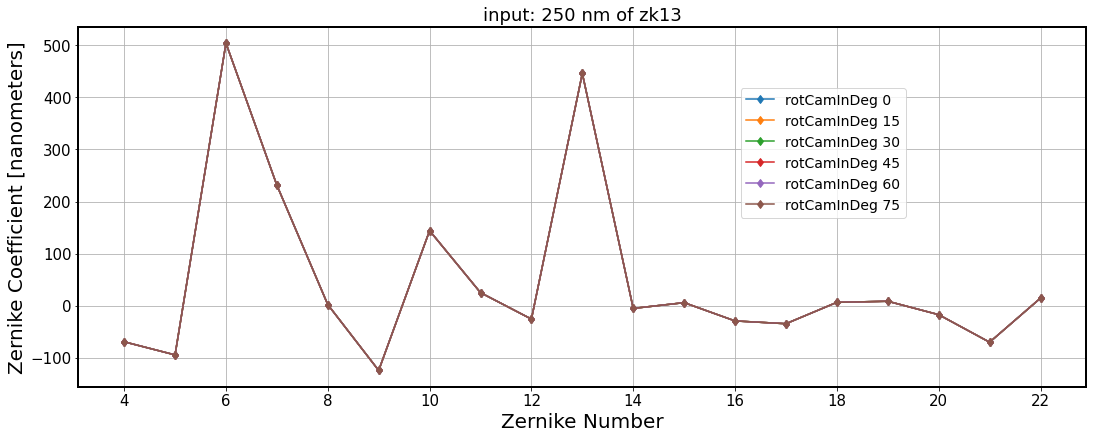

In [22]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# common functions for AOS analysis
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 
zkInput = 12
#rotCamInDeg = 0
#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,1,1])
ax1.set_title(f'input: 250 nm of zk{zkInput+1}')
for rotCamInDeg in zkResults[zkInput].keys():
    zkRaw  = zkResults[zkInput][rotCamInDeg]
    
    ax1.plot(np.arange(4, 23),1000*zkRaw, 
                 '-d', label=f'rotCamInDeg {rotCamInDeg}')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()


All look identical to me, so it looks like regardless of `rotSkyPos`, the zernikes are exactly the same for the given input...

In [45]:
data_dir = '/project/scichris/aos/rotation_DM-34065/test02_b/'
repoDir = os.path.join(data_dir, 'phosimData')
butler  = dafButler.Butler(repoDir)

In [46]:
collections = butler.registry.queryCollections("ts_phosim*")
for collection in collections:
    print(collection)

ts_phosim_9000002
ts_phosim_9000012
ts_phosim_9000022
ts_phosim_9000032
ts_phosim_9000042
ts_phosim_9000052
ts_phosim_9000062
ts_phosim_9000072
ts_phosim_9000082
ts_phosim_9000092
ts_phosim_9000102
ts_phosim_9000112
ts_phosim_9000122
ts_phosim_9000132
ts_phosim_9000142
ts_phosim_9000152
ts_phosim_9000162
ts_phosim_9000172
ts_phosim_9000182
ts_phosim_9015002
ts_phosim_9015012
ts_phosim_9015022
ts_phosim_9015032
ts_phosim_9015042
ts_phosim_9015052
ts_phosim_9015062
ts_phosim_9015072
ts_phosim_9015082
ts_phosim_9015092
ts_phosim_9015102
ts_phosim_9015112
ts_phosim_9015122
ts_phosim_9015132
ts_phosim_9015142
ts_phosim_9015152
ts_phosim_9015162
ts_phosim_9015172
ts_phosim_9015182
ts_phosim_9030002
ts_phosim_9030012
ts_phosim_9030022
ts_phosim_9030032
ts_phosim_9030042
ts_phosim_9030052
ts_phosim_9030062
ts_phosim_9030072
ts_phosim_9030082
ts_phosim_9030092
ts_phosim_9030102
ts_phosim_9030112
ts_phosim_9030122
ts_phosim_9030132
ts_phosim_9030142
ts_phosim_9030152
ts_phosim_9030162
ts_phosim_

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123175102}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123175102}


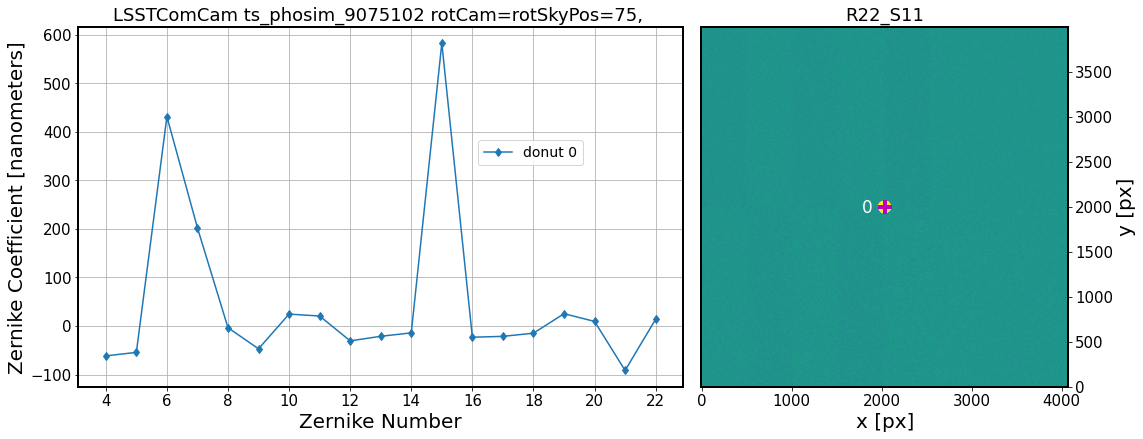

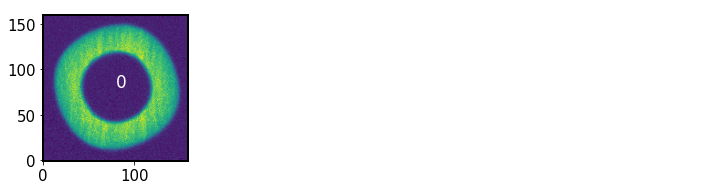

In [47]:
import os
import sys
sys.path.append('/project/scichris/aos/')
import analysisTools as at
import imp
imp.reload(at)

%matplotlib inline
data_dir = '/project/scichris/aos/rotation_DM-34065/test02_b/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_9075102',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=75, ')



{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123160102}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123160102}


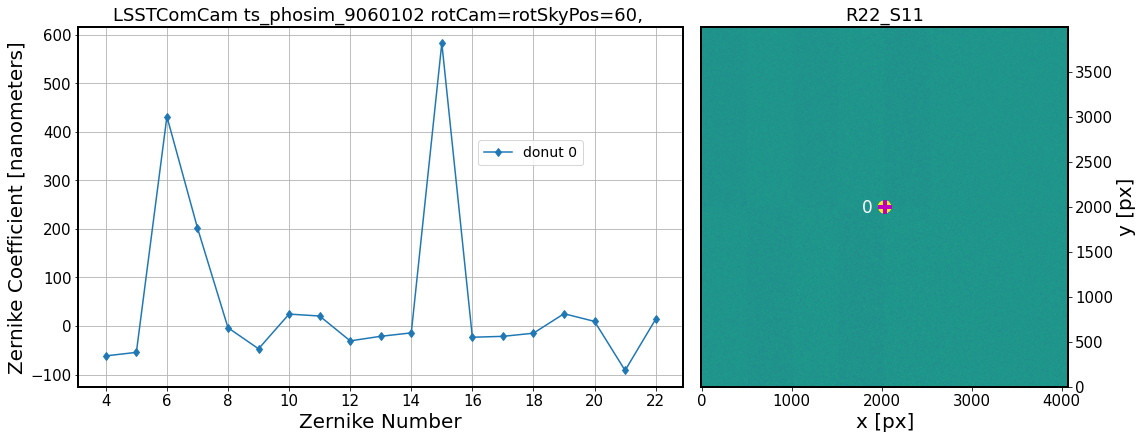

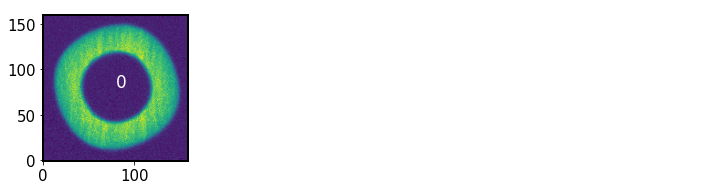

In [48]:
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_9060102',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=60, ')


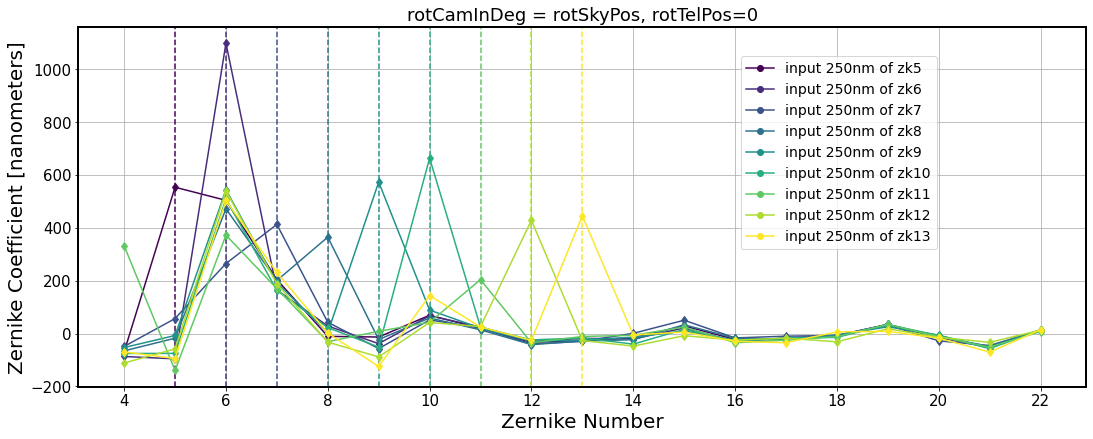

In [23]:
import matplotlib.lines as mlines
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0,0,1,1])

####################################
### left - plot the fit results  ###
#################################### 


nlines = len(np.arange(4,13))
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis
i =0 
for zkInput in np.arange(4,13):# 12
    rotCamInDeg = 0 # just plot the 0 deg since regardless of rotCamInDeg the results are identical 
    #add_axes([xmin,ymin,dx,dy]) 
    
    #for rotCamInDeg in zkResults[zkInput].keys():
    zkRaw  = zkResults[zkInput][rotCamInDeg]
    color = cmap(color_idx[i])
    ax1.plot(np.arange(4, 23),1000*zkRaw, 
                 '-d', 
             color=color)
    line = mlines.Line2D([], [], color=color,label=f'input 250nm of zk{zkInput+1}',
                         ls='-', marker='o', alpha=1,)
    ax1.axvline(zkInput+1, ls='--',color=color)
    ax_legend_handles.append(line)
    i += 1 
#ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1, 0.5],ncol=1)
ax1.set_title('rotCamInDeg = rotSkyPos, rotTelPos=0')
ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
plt.legend(handles=ax_legend_handles,fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()


The dashed vertical line indicates the input zernike number. The color of the dashed line matches the color of the fit (solid line) for a simulation perturbed with that particular zk. 

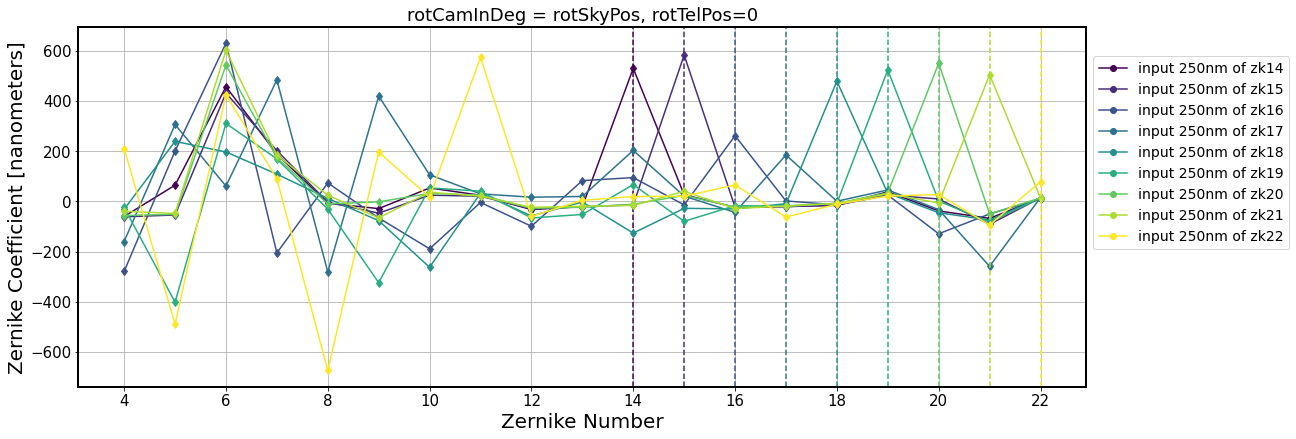

In [24]:
import matplotlib.lines as mlines
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0,0,1,1])

####################################
### left - plot the fit results  ###
#################################### 


nlines = len(np.arange(4,13))
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis
i =0 
for zkInput in np.arange(13,22):# 12
    rotCamInDeg = 0 # just plot the 0 deg since regardless of rotCamInDeg the results are identical 
    #add_axes([xmin,ymin,dx,dy]) 
    
    #for rotCamInDeg in zkResults[zkInput].keys():
    zkRaw  = zkResults[zkInput][rotCamInDeg]
    color = cmap(color_idx[i])
    ax1.plot(np.arange(4, 23),1000*zkRaw, 
                 '-d', 
             color=color)
    line = mlines.Line2D([], [], color=color,label=f'input 250nm of zk{zkInput+1}',
                         ls='-', marker='o', alpha=1,)
    ax1.axvline(zkInput+1, ls='--',color=color)
    ax_legend_handles.append(line)
    i += 1 
#ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1, 0.5],ncol=1)
ax1.set_title('rotCamInDeg = rotSkyPos, rotTelPos=0')
ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
plt.legend(handles=ax_legend_handles,fontsize=14, loc='center left', bbox_to_anchor=[1., 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()


# `test02_c` : `rotCamInDeg = rotTelPos , no rotSkyPos` 

I modified `test02_runZk.py` to have `rotCamInDeg` passed as `rotTelPos` into `inst` file. ( perhaps make it a kwarg later). I also changed the default `baseOutputDir` to `test02_c`.  

Also corrected the `izernike` command, so that it passes `1+zkNumber` since numbering in `phosim` cmd file starts from 0... 

Submit the modified slurm scripts:
    
    cp runSlurm_zk_rotCam_15.sl runSlurm_zk_rotCam_0_c.sl
    
    sbatch runSlurm_zk_rotCam_0_c.sl   ( 60495 )
    0 : 60495 - running just fine 
    15 : 60496 - run too early, before refcats were run - need to resubmit 
    30 : 60497 - run too early, before refcats were run - need to resubmit 
    45 : 60498 - run too early, before refcats were run - need to resubmit 
    60 : 60499 - running just fine 
    75 : 60500 - running just fine 
    90 : 60501 - running just fine 
    
    15 : 60502 sbatch runSlurm_zk_rotCam_15.sl 
    30 : 60503 sbatch runSlurm_zk_rotCam_30.sl 
    45 : 60504 sbatch runSlurm_zk_rotCam_45.sl 
    
    these three last ones have issues because such datasets got already ingested into the repo, but the failure was at the donut detection stage as it complained of there being no refcats...
    
    So need to remove-runs .. or remove-collections .... to be able to run 15,30,45... 

Instead of running along the entire range of parameters, query for existing collections:

In [1]:
import os
from lsst.daf import butler as dafButler
import numpy as np



In [2]:
def makeJcountDic():
    # Make the dict of zk to jcount
    jcount = 0
    jcountDic = {}
    for zkNumber in np.arange(4, 23):
        #print(zkNumber, jcount)
        jcountDic[zkNumber] = jcount
        jcount += 1
    return jcountDic

zkDic = {}
jcountDic = makeJcountDic()
for zkNumber in jcountDic.keys():
    jcount = jcountDic[zkNumber]
    zkDic[jcount] = zkNumber
    
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_c'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

collections = butler.registry.queryCollections("ts_phosim*")

# make a dictionary to store the results 
zkResults={}
for zkNumber in np.arange(4,23):
    zkResults[zkNumber] = {}
    
# loop over collections and put whatever results are available 
# into a dic 
for collection in collections:
    
    obsIdStr = collection.split('_')[2] # extra 
    rotCamInDeg = int(obsIdStr[2:4])
    jcount = int(obsIdStr[4:6])
    zkNumber = zkDic[jcount]
    
    print(f'Reading {obsIdStr}, with  rotCamInDeg={rotCamInDeg}, jcount={jcount}, i.e. zkNumber={zkNumber}')

    datasetRefs = butler.registry.queryDatasets(
                datasetType="zernikeEstimateAvg", collections=[collection]
            )

    listOfWfErr = []

    for dataset in datasetRefs:
        dataId = {
            "instrument": dataset.dataId["instrument"],
            "detector": dataset.dataId["detector"],
            "visit": dataset.dataId["visit"],
        }

        zerCoeff = butler.get(
            "zernikeEstimateAvg",
            dataId=dataId,
            collections=[collection],
        )

        listOfWfErr.append(zerCoeff)

    zkResults[zkNumber][rotCamInDeg] = listOfWfErr[0]
            


Reading 9000002, with  rotCamInDeg=0, jcount=0, i.e. zkNumber=4
Reading 9000012, with  rotCamInDeg=0, jcount=1, i.e. zkNumber=5
Reading 9000022, with  rotCamInDeg=0, jcount=2, i.e. zkNumber=6
Reading 9000032, with  rotCamInDeg=0, jcount=3, i.e. zkNumber=7
Reading 9000042, with  rotCamInDeg=0, jcount=4, i.e. zkNumber=8
Reading 9000052, with  rotCamInDeg=0, jcount=5, i.e. zkNumber=9
Reading 9000062, with  rotCamInDeg=0, jcount=6, i.e. zkNumber=10
Reading 9000072, with  rotCamInDeg=0, jcount=7, i.e. zkNumber=11
Reading 9000082, with  rotCamInDeg=0, jcount=8, i.e. zkNumber=12
Reading 9000092, with  rotCamInDeg=0, jcount=9, i.e. zkNumber=13
Reading 9000102, with  rotCamInDeg=0, jcount=10, i.e. zkNumber=14
Reading 9000112, with  rotCamInDeg=0, jcount=11, i.e. zkNumber=15
Reading 9000122, with  rotCamInDeg=0, jcount=12, i.e. zkNumber=16
Reading 9000132, with  rotCamInDeg=0, jcount=13, i.e. zkNumber=17
Reading 9000142, with  rotCamInDeg=0, jcount=14, i.e. zkNumber=18
Reading 9000152, with  rot

Also, read in the `15`,`30`,`45` run in  a different repo  `test02_c2`; use the same `zkResults` dictionary::

In [3]:
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_c2'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

collections = butler.registry.queryCollections("ts_phosim*")

    
# loop over collections and put whatever results are available 
# into a dic 
for collection in collections:
    
    obsIdStr = collection.split('_')[2] # extra 
    rotCamInDeg = int(obsIdStr[2:4])
    jcount = int(obsIdStr[4:6])
    zkNumber = zkDic[jcount]
    
    print(f'Reading {obsIdStr}, with  rotCamInDeg={rotCamInDeg}, jcount={jcount}, i.e. zkNumber={zkNumber}')

    datasetRefs = butler.registry.queryDatasets(
                datasetType="zernikeEstimateAvg", collections=[collection]
            )

    listOfWfErr = []

    for dataset in datasetRefs:
        dataId = {
            "instrument": dataset.dataId["instrument"],
            "detector": dataset.dataId["detector"],
            "visit": dataset.dataId["visit"],
        }

        zerCoeff = butler.get(
            "zernikeEstimateAvg",
            dataId=dataId,
            collections=[collection],
        )

        listOfWfErr.append(zerCoeff)

    zkResults[zkNumber][rotCamInDeg] = listOfWfErr[0]
            


Reading 9015002, with  rotCamInDeg=15, jcount=0, i.e. zkNumber=4
Reading 9015012, with  rotCamInDeg=15, jcount=1, i.e. zkNumber=5
Reading 9015022, with  rotCamInDeg=15, jcount=2, i.e. zkNumber=6
Reading 9015032, with  rotCamInDeg=15, jcount=3, i.e. zkNumber=7
Reading 9015042, with  rotCamInDeg=15, jcount=4, i.e. zkNumber=8
Reading 9015052, with  rotCamInDeg=15, jcount=5, i.e. zkNumber=9
Reading 9015062, with  rotCamInDeg=15, jcount=6, i.e. zkNumber=10
Reading 9015072, with  rotCamInDeg=15, jcount=7, i.e. zkNumber=11
Reading 9015082, with  rotCamInDeg=15, jcount=8, i.e. zkNumber=12
Reading 9015092, with  rotCamInDeg=15, jcount=9, i.e. zkNumber=13
Reading 9015102, with  rotCamInDeg=15, jcount=10, i.e. zkNumber=14
Reading 9015112, with  rotCamInDeg=15, jcount=11, i.e. zkNumber=15
Reading 9015122, with  rotCamInDeg=15, jcount=12, i.e. zkNumber=16
Reading 9015132, with  rotCamInDeg=15, jcount=13, i.e. zkNumber=17
Reading 9015142, with  rotCamInDeg=15, jcount=14, i.e. zkNumber=18
Reading 901

Also, add to that dic all the data that already got run in `test02_c3` with new `obsHistId` scheme ,...

In [4]:
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_c3'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

collections = butler.registry.queryCollections("ts_phosim*")

    
# loop over collections and put whatever results are available 
# into a dic 
for collection in collections:
    #print(collection)
    obsIdStr = collection.split('_')[2] # extra-focal  has 10 added to zkNumber 
    rotCamInDeg = int(obsIdStr[2:5])
    zkNumber = int(obsIdStr[-2:])-10 # so I subtract 10 to recover zkNumber
    
    print(f'Reading {obsIdStr}, with  rotCamInDeg={rotCamInDeg},  zkNumber={zkNumber}')
    
    datasetRefs = butler.registry.queryDatasets(
                datasetType="zernikeEstimateAvg", collections=[collection]
            )

    listOfWfErr = []

    for dataset in datasetRefs:
        dataId = {
            "instrument": dataset.dataId["instrument"],
            "detector": dataset.dataId["detector"],
            "visit": dataset.dataId["visit"],
        }

        zerCoeff = butler.get(
            "zernikeEstimateAvg",
            dataId=dataId,
            collections=[collection],
        )

        listOfWfErr.append(zerCoeff)

    zkResults[zkNumber][rotCamInDeg] = listOfWfErr[0]
    

Reading 9010514, with  rotCamInDeg=105,  zkNumber=4
Reading 9010515, with  rotCamInDeg=105,  zkNumber=5
Reading 9010516, with  rotCamInDeg=105,  zkNumber=6
Reading 9010517, with  rotCamInDeg=105,  zkNumber=7
Reading 9010518, with  rotCamInDeg=105,  zkNumber=8
Reading 9010519, with  rotCamInDeg=105,  zkNumber=9
Reading 9010520, with  rotCamInDeg=105,  zkNumber=10
Reading 9010521, with  rotCamInDeg=105,  zkNumber=11
Reading 9010522, with  rotCamInDeg=105,  zkNumber=12
Reading 9010523, with  rotCamInDeg=105,  zkNumber=13
Reading 9010524, with  rotCamInDeg=105,  zkNumber=14
Reading 9010525, with  rotCamInDeg=105,  zkNumber=15
Reading 9010526, with  rotCamInDeg=105,  zkNumber=16
Reading 9010527, with  rotCamInDeg=105,  zkNumber=17
Reading 9010528, with  rotCamInDeg=105,  zkNumber=18
Reading 9010529, with  rotCamInDeg=105,  zkNumber=19
Reading 9010530, with  rotCamInDeg=105,  zkNumber=20
Reading 9010531, with  rotCamInDeg=105,  zkNumber=21
Reading 9010532, with  rotCamInDeg=105,  zkNumber=22

Reading 9022519, with  rotCamInDeg=225,  zkNumber=9
Reading 9022520, with  rotCamInDeg=225,  zkNumber=10
Reading 9022521, with  rotCamInDeg=225,  zkNumber=11
Reading 9022522, with  rotCamInDeg=225,  zkNumber=12
Reading 9022523, with  rotCamInDeg=225,  zkNumber=13
Reading 9022524, with  rotCamInDeg=225,  zkNumber=14
Reading 9022525, with  rotCamInDeg=225,  zkNumber=15
Reading 9022526, with  rotCamInDeg=225,  zkNumber=16
Reading 9022527, with  rotCamInDeg=225,  zkNumber=17
Reading 9022528, with  rotCamInDeg=225,  zkNumber=18
Reading 9022529, with  rotCamInDeg=225,  zkNumber=19
Reading 9022530, with  rotCamInDeg=225,  zkNumber=20
Reading 9022531, with  rotCamInDeg=225,  zkNumber=21
Reading 9022532, with  rotCamInDeg=225,  zkNumber=22
Reading 9024014, with  rotCamInDeg=240,  zkNumber=4
Reading 9024015, with  rotCamInDeg=240,  zkNumber=5
Reading 9024016, with  rotCamInDeg=240,  zkNumber=6
Reading 9024017, with  rotCamInDeg=240,  zkNumber=7
Reading 9024018, with  rotCamInDeg=240,  zkNumber=8

Reading 9035524, with  rotCamInDeg=355,  zkNumber=14
Reading 9035525, with  rotCamInDeg=355,  zkNumber=15
Reading 9035526, with  rotCamInDeg=355,  zkNumber=16
Reading 9035527, with  rotCamInDeg=355,  zkNumber=17
Reading 9035528, with  rotCamInDeg=355,  zkNumber=18
Reading 9035529, with  rotCamInDeg=355,  zkNumber=19
Reading 9035530, with  rotCamInDeg=355,  zkNumber=20
Reading 9035531, with  rotCamInDeg=355,  zkNumber=21
Reading 9035532, with  rotCamInDeg=355,  zkNumber=22


In [5]:
obsIdStr = collection.split('_')[2]


In [9]:

int(obsIdStr[-2:])-10


7

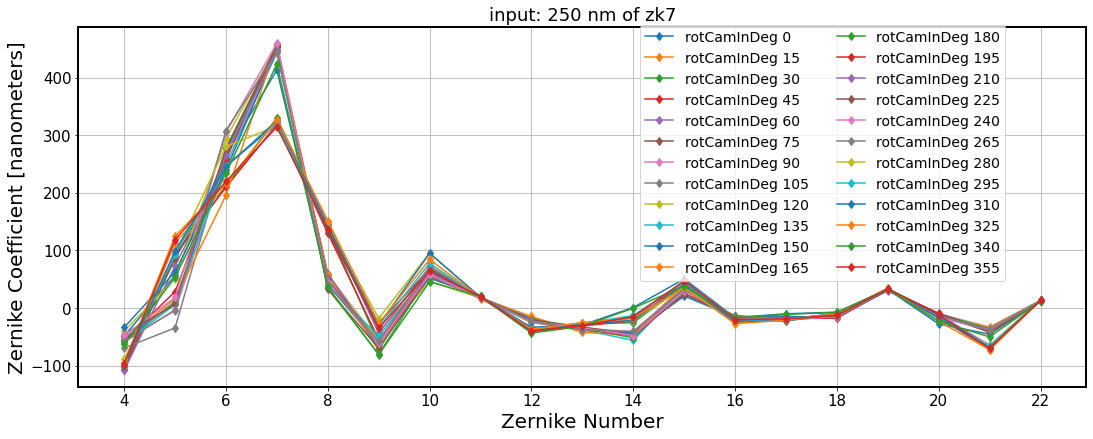

In [35]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# common functions for AOS analysis
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 
zkInput = 7 
#rotCamInDeg = 0
#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,1,1])
ax1.set_title(f'input: 250 nm of zk{zkInput}')
rotCamInDeg_ = np.sort(list(zkResults[zkInput].keys()))
for rotCamInDeg in rotCamInDeg_:
    zkRaw  = zkResults[zkInput][rotCamInDeg]
    
    ax1.plot(np.arange(4, 23),1000*zkRaw, 
                 '-d', label=f'rotCamInDeg {rotCamInDeg}')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.55, 0.65], ncol=2)
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()


Change the color scheme to continuous. 

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123100092}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123100092}


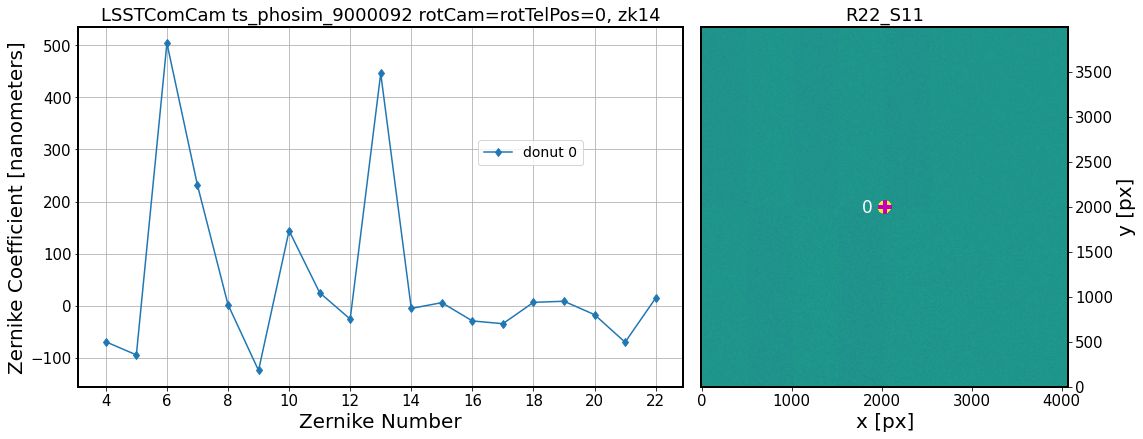

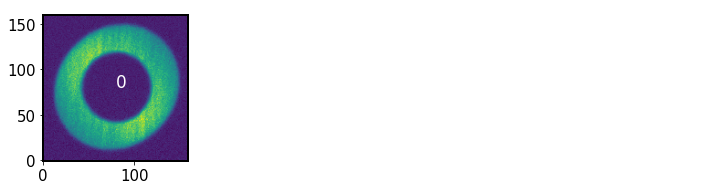

In [60]:
data_dir = '/project/scichris/aos/rotation_DM-34065/test02_c/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_9000092',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotTelPos=0, zk14')


{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123190092}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123190092}


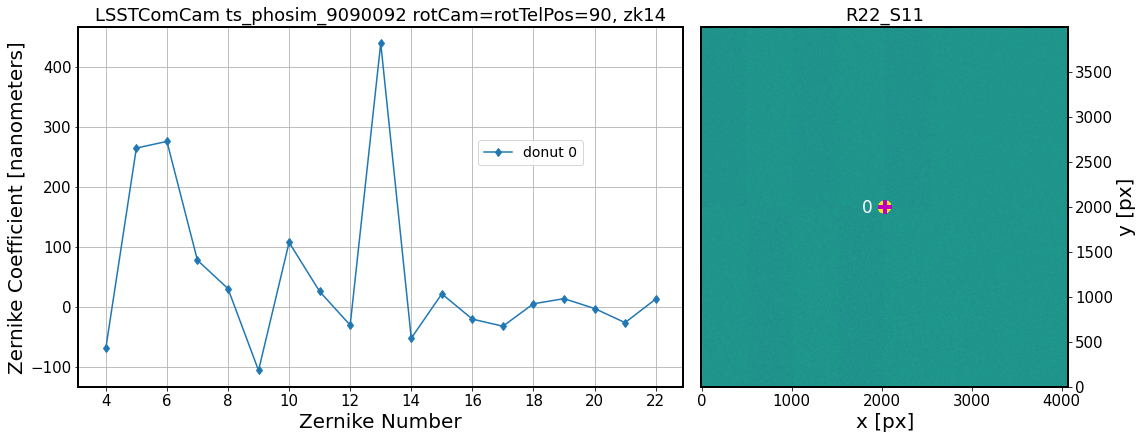

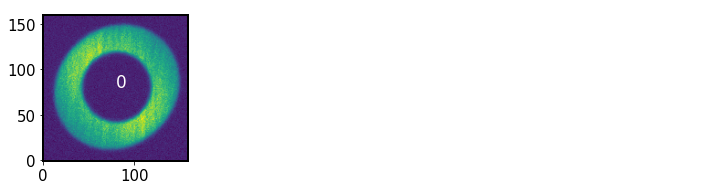

In [61]:
data_dir = '/project/scichris/aos/rotation_DM-34065/test02_c/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_9090092',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotTelPos=90, zk14')

#9090102

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123130092}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123130092}


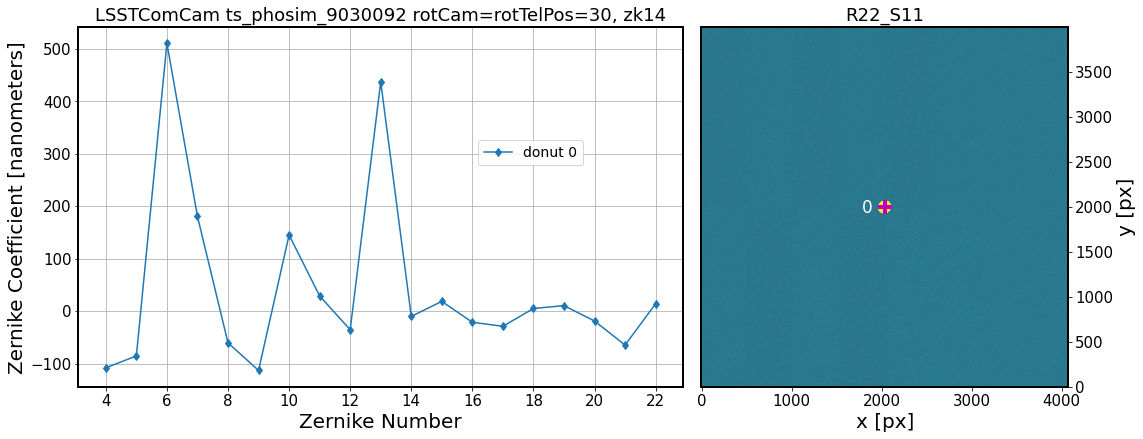

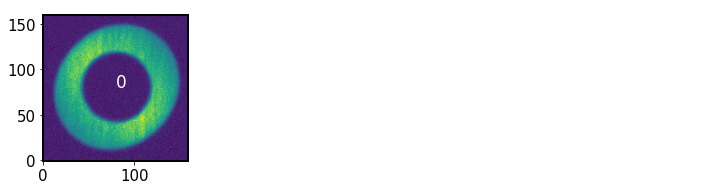

In [62]:
data_dir = '/project/scichris/aos/rotation_DM-34065/test02_c2/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_9030092',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotTelPos=30, zk14')


## For a given input zk, plot the recovered zk as a function of rotCamInDeg .... 



Expect: 
    
    Z4, Z11, Z22 estimated Zernikes are independent of input rotation angle.
    Z7, Z8, Z16, Z17 period is 360 degrees
    Z5, Z6, Z12, Z13 period is 180 degrees
    Z9, Z10, Z18, Z19 period is 120 degrees
    Z14, Z15, period is 90 degrees
    Z20, Z21, period is 72 degrees
    

In [9]:
def plotFitZernikeVsRotCamInDeg(zkResults, zkInput=20, zkPlot):
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_axes([0,0,1,1])


    rotCamInDeg_ = np.sort(list(zkResults[zkInput].keys()))

    #for zkInput in [20,21]:
    #zkInput=20
    ax1.set_title(f'input: 250 nm of zk{zkInput}')
    zkFit_ = []
    for rotCamInDeg in rotCamInDeg_:
        zkRaw  = zkResults[zkInput][rotCamInDeg] # this array starts from zk4-zk22
        zkFit = zkRaw[zkInput-4]
        zkFit_.append(zkFit)

    ax1.plot(rotCamInDeg_, 1000*np.array(zkFit_), '-D', label=f'zk {zkInput}')
    #ax1.legend()
    ax1.set_xlabel('rotCamInDeg(=rotTelPos)')
    ax1.set_ylabel('fit zk [nm]')
    

### "Z20, Z21, period is 72 degrees":

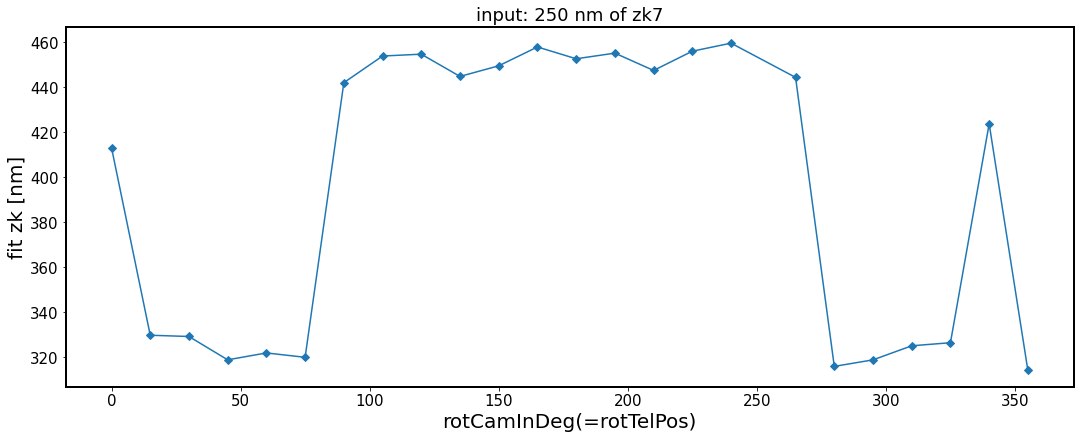

In [36]:

plotFitZernikeVsRotCamInDeg(zkResults, zkInput=7)


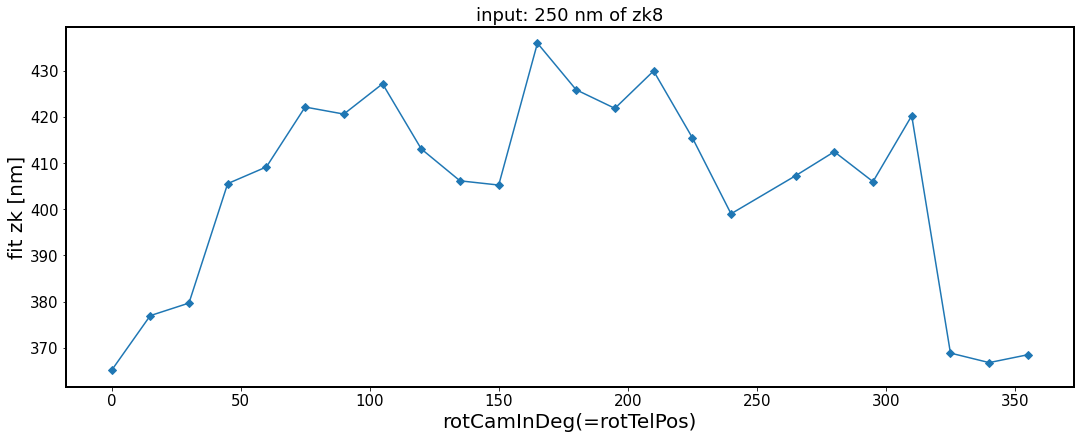

In [37]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=8)

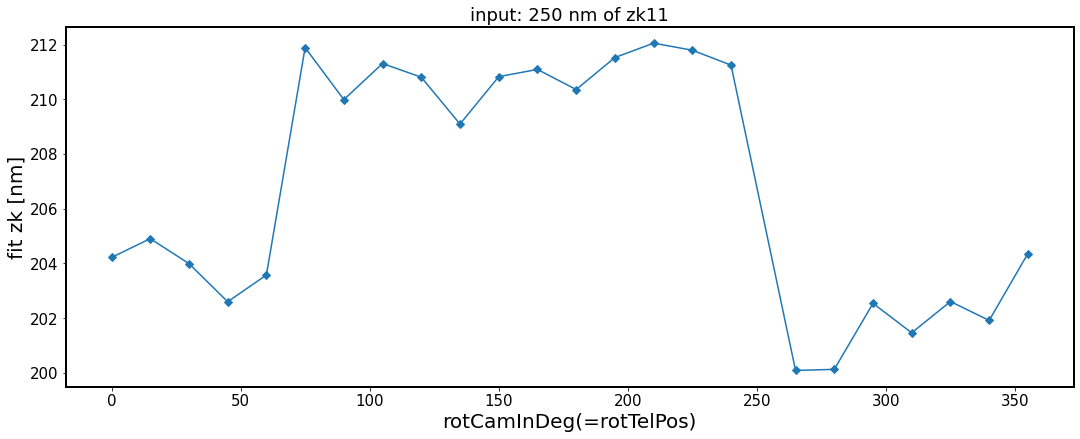

In [34]:

plotFitZernikeVsRotCamInDeg(zkResults, zkInput=11)


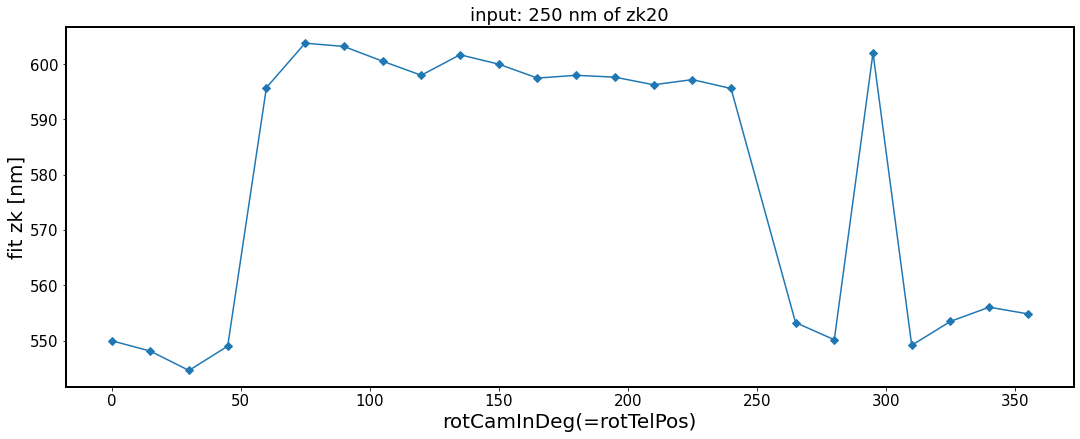

In [10]:

plotFitZernikeVsRotCamInDeg(zkResults, zkInput=20)


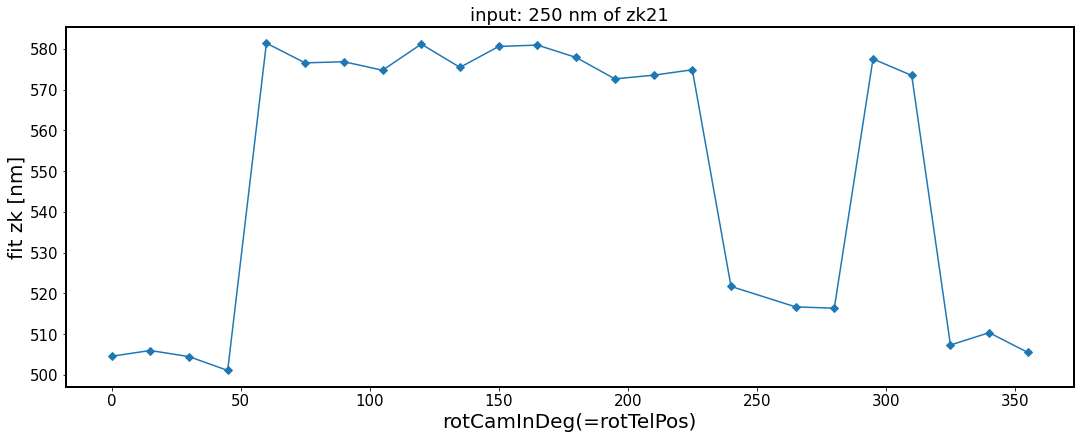

In [11]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=21)


### "Z14, Z15, period is 90 degrees"

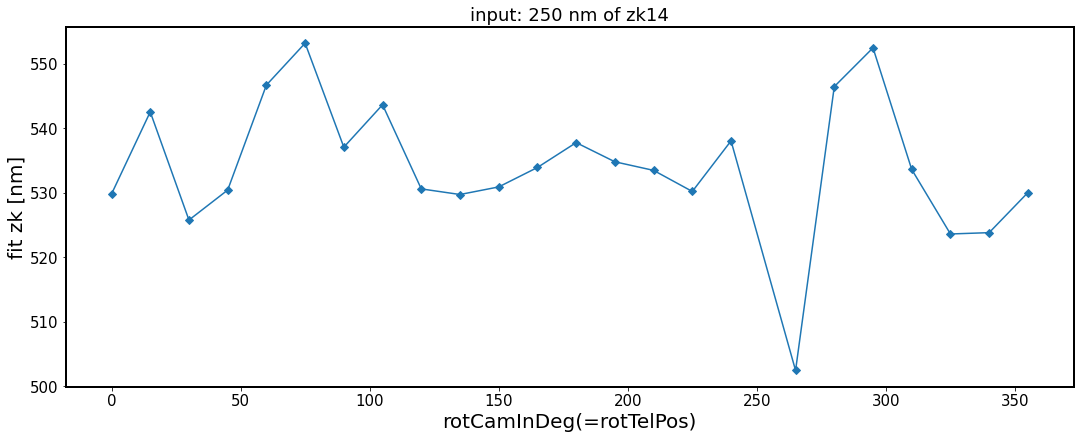

In [12]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=14)


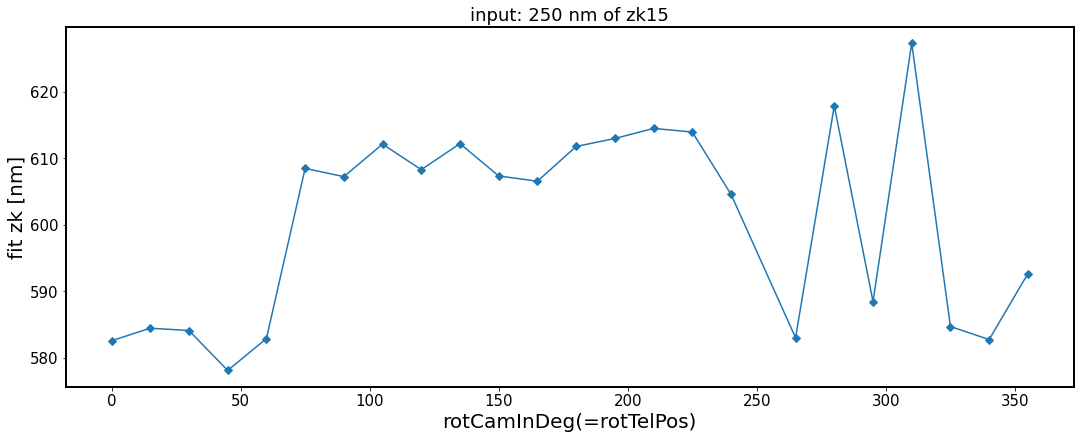

In [13]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=15)


 ### "Z9, Z10, Z18, Z19 period is 120 degrees"

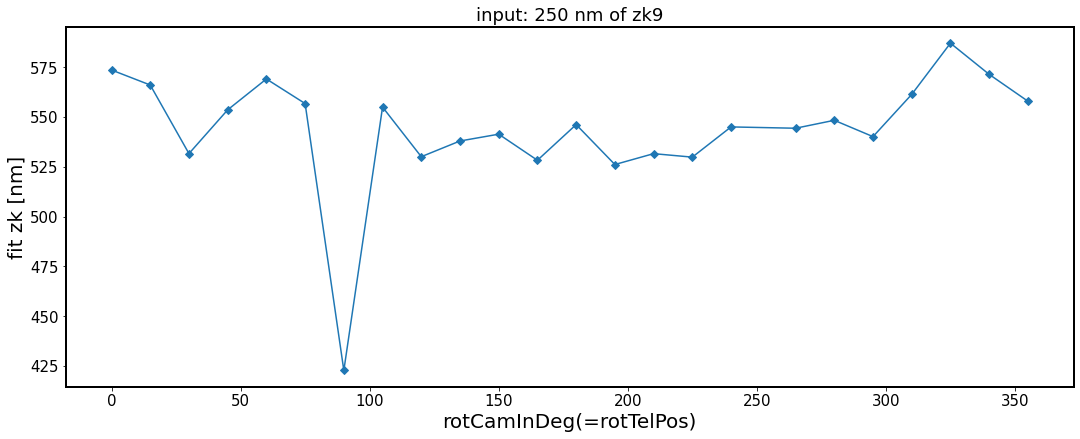

In [14]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=9)


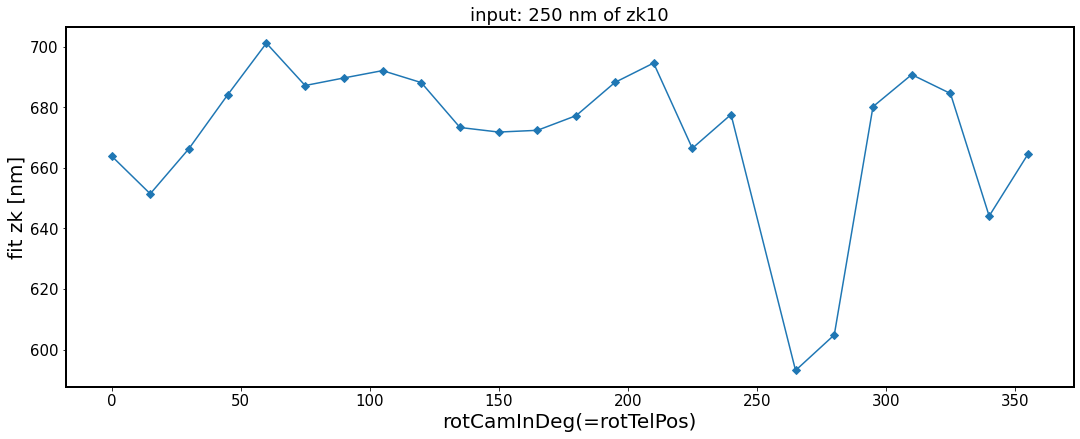

In [16]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=10)


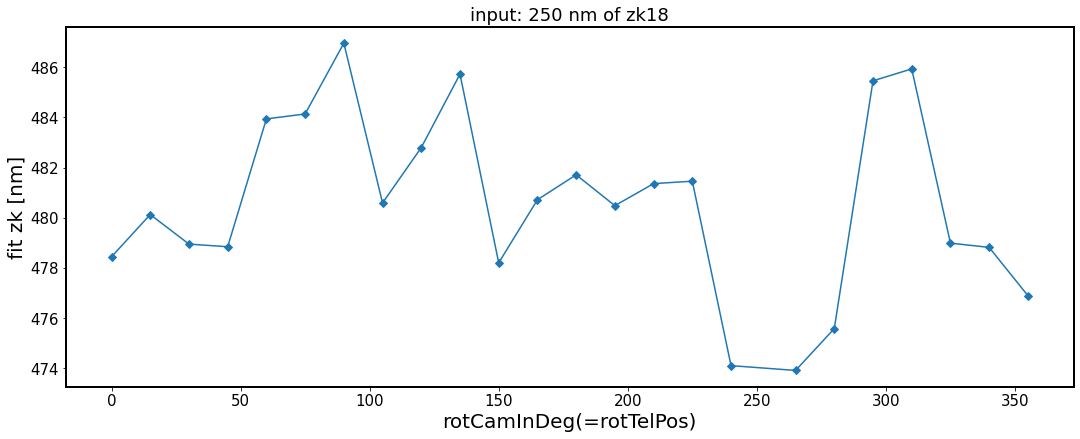

In [17]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=18)


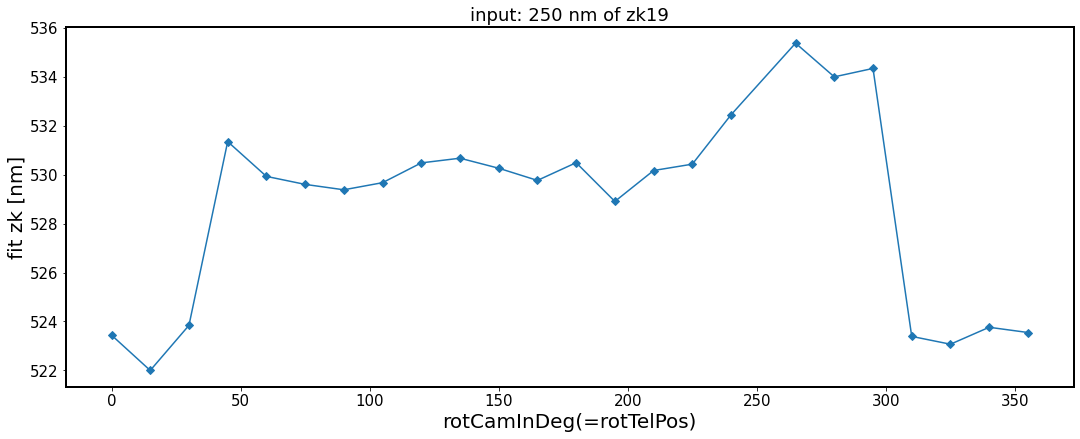

In [18]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=19)


### "Z5, Z6, Z12, Z13 period is 180 degrees"

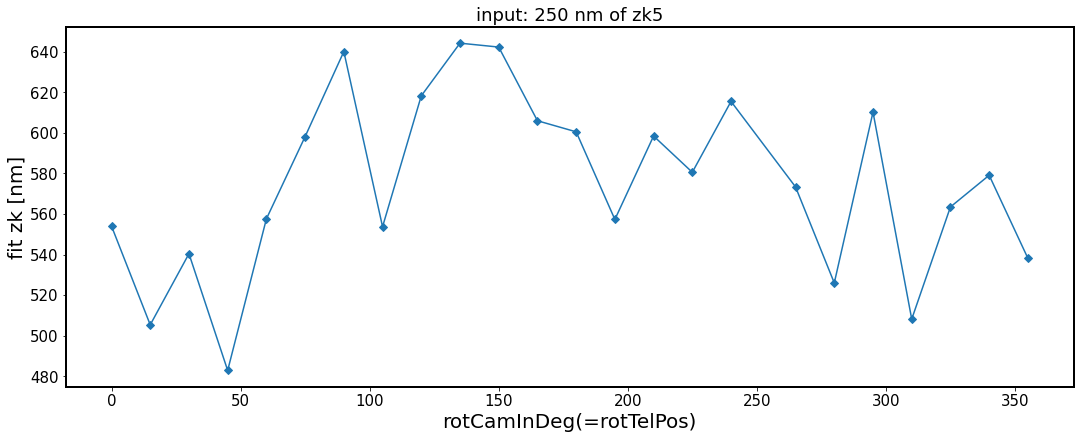

In [19]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=5)


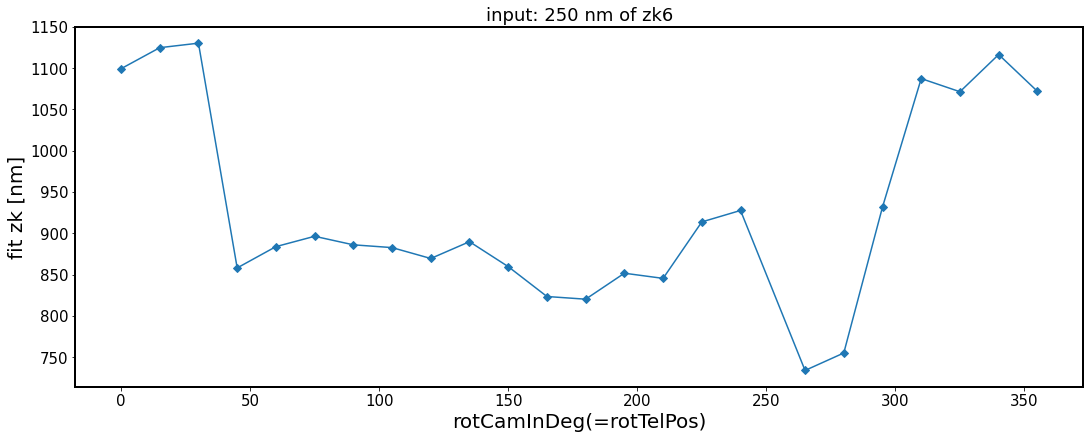

In [20]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=6)


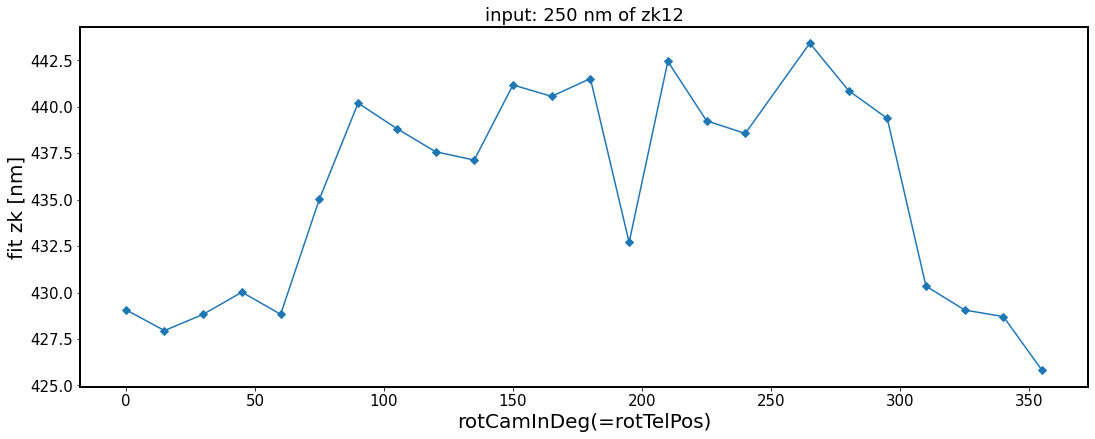

In [21]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=12)


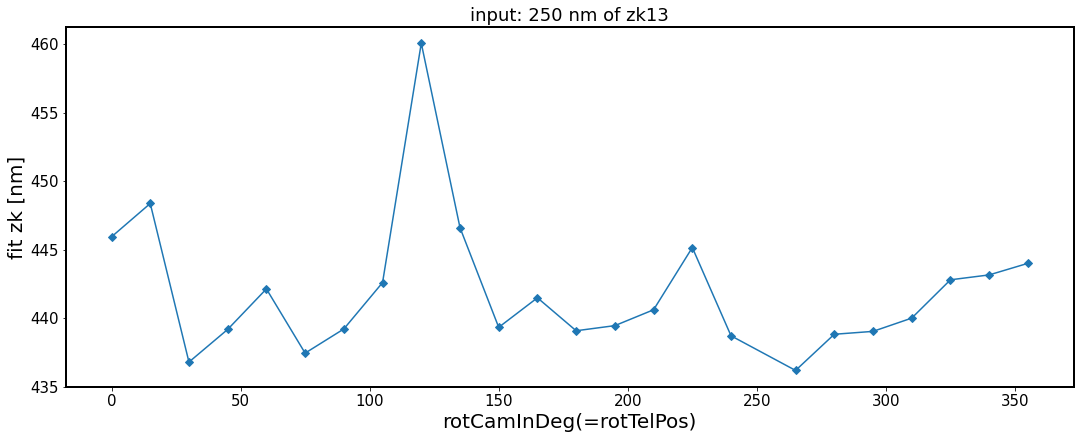

In [22]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=13)


### "Z7, Z8, Z16, Z17 period is 360 degrees"

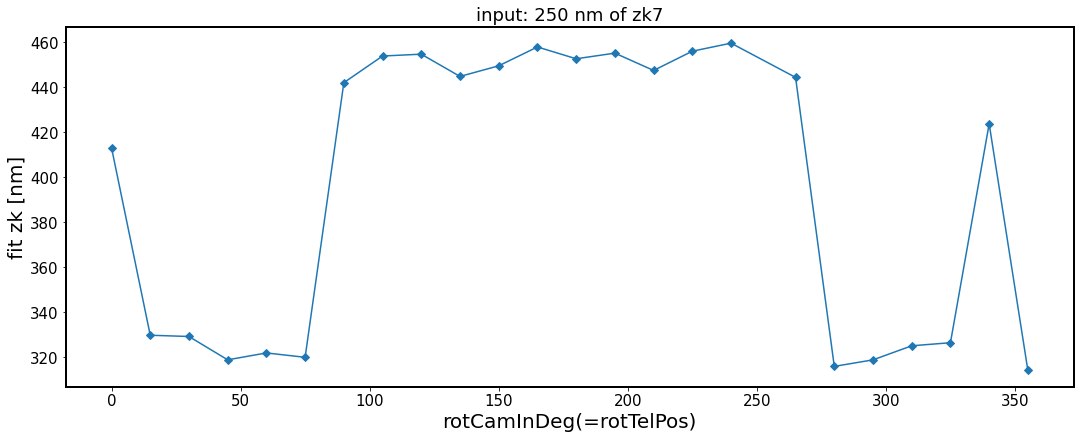

In [23]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=7)


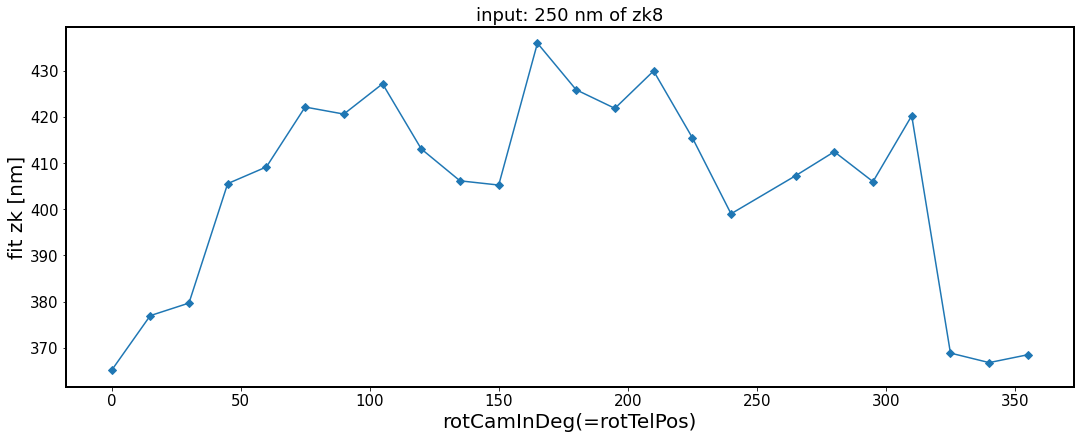

In [24]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=8)


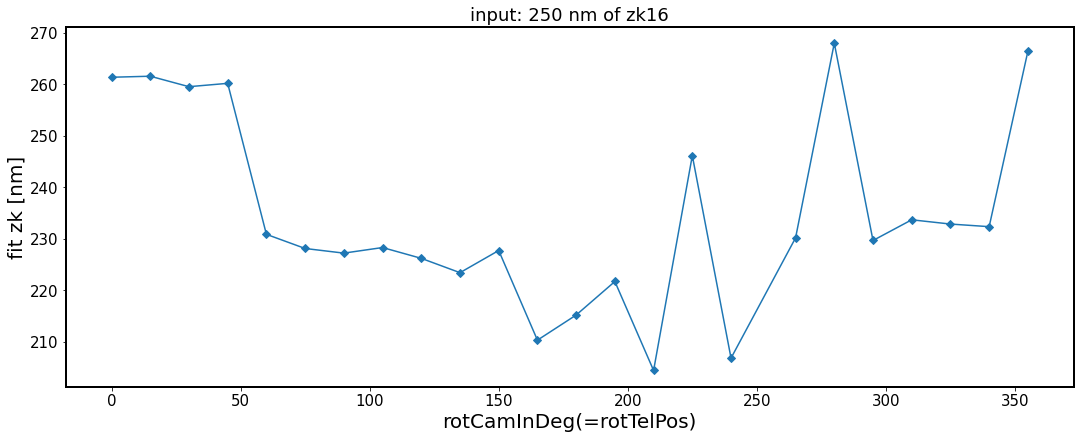

In [25]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=16)


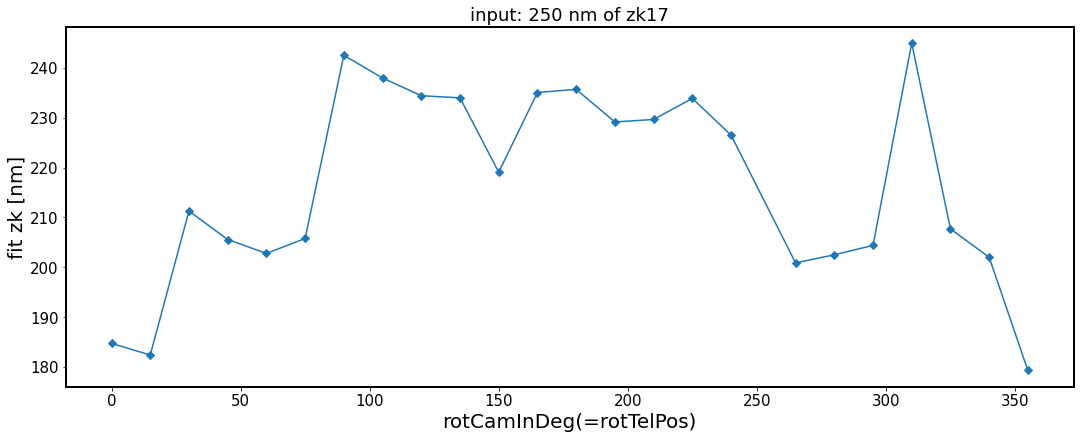

In [26]:
plotFitZernikeVsRotCamInDeg(zkResults, zkInput=17)


They are not the same. That's good! I need  a solution that would bascially allow `clobber = True` for `butler.put`, because all those `dataIds` that already exist there are messed up and I'd love to be able to simply overwrite them...


So how can I do https://lsstc.slack.com/archives/C01FBUGM2CV/p1630588267190400 ? 

In [130]:
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_c'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)


Plot different `z`k for a fixed `rotCamInDeg` (rotTelPos) : 

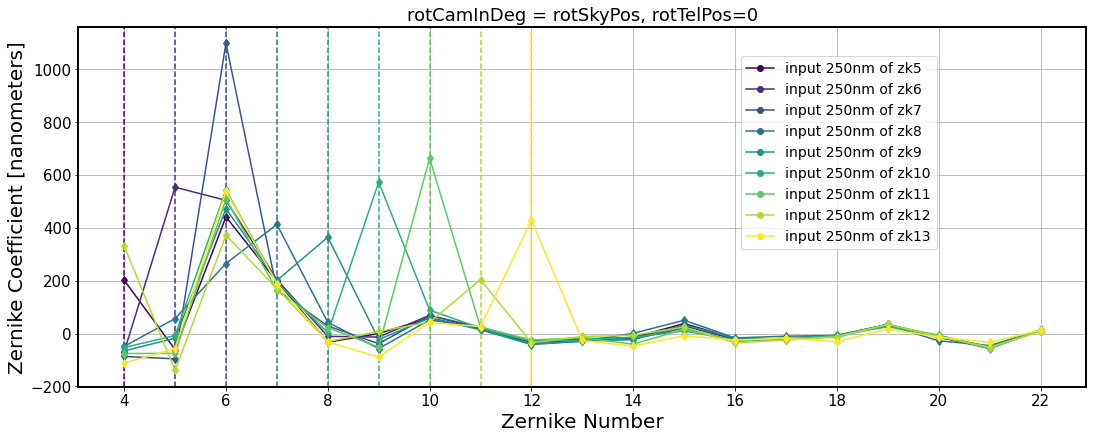

In [49]:
import matplotlib.lines as mlines
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0,0,1,1])

####################################
### left - plot the fit results  ###
#################################### 


nlines = len(np.arange(4,13))
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis
i =0 
for zkInput in np.arange(4,13):# 12
    rotCamInDeg =  0
    #add_axes([xmin,ymin,dx,dy]) 
    
    #for rotCamInDeg in zkResults[zkInput].keys():
    zkRaw  = zkResults[zkInput][rotCamInDeg]
    color = cmap(color_idx[i])
    ax1.plot(np.arange(4, 23),1000*zkRaw, 
                 '-d', 
             color=color)
    line = mlines.Line2D([], [], color=color,label=f'input 250nm of zk{zkInput+1}',
                         ls='-', marker='o', alpha=1,)
    ax1.axvline(zkInput, ls='--',color=color)
    ax_legend_handles.append(line)
    i += 1 
#ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1, 0.5],ncol=1)
ax1.set_title('rotCamInDeg = rotSkyPos, rotTelPos=0')
ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
plt.legend(handles=ax_legend_handles,fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()


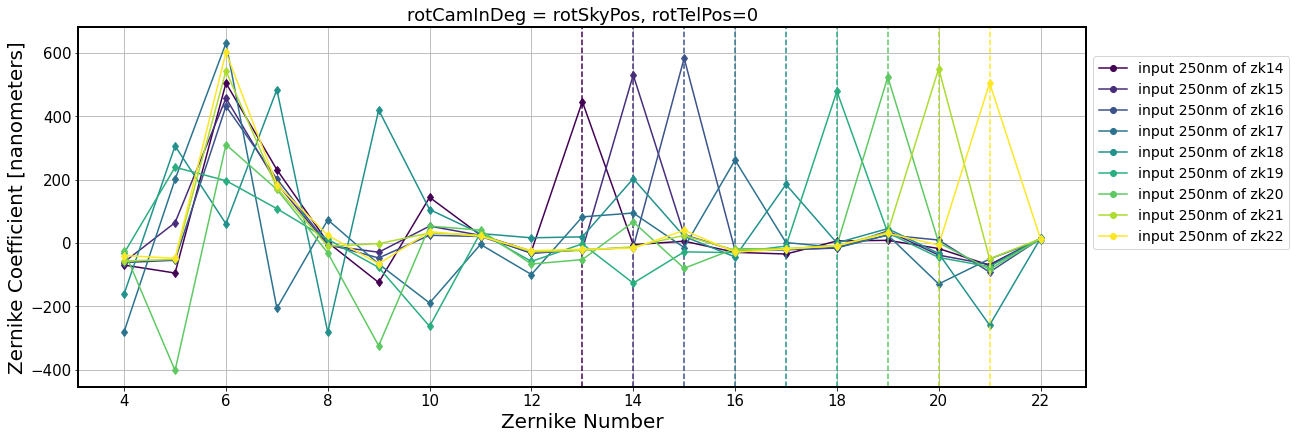

In [50]:
import matplotlib.lines as mlines
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0,0,1,1])

####################################
### left - plot the fit results  ###
#################################### 


nlines = len(np.arange(4,13))
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis
i =0 
for zkInput in np.arange(13,22):# 12
    rotCamInDeg = 0 # just plot the 0 deg since regardless of rotCamInDeg the results are identical 
    #add_axes([xmin,ymin,dx,dy]) 
    
    #for rotCamInDeg in zkResults[zkInput].keys():
    zkRaw  = zkResults[zkInput][rotCamInDeg]
    color = cmap(color_idx[i])
    ax1.plot(np.arange(4, 23),1000*zkRaw, 
                 '-d', 
             color=color)
    line = mlines.Line2D([], [], color=color,label=f'input 250nm of zk{zkInput+1}',
                         ls='-', marker='o', alpha=1,)
    ax1.axvline(zkInput, ls='--',color=color)
    ax_legend_handles.append(line)
    i += 1 
#ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1, 0.5],ncol=1)
ax1.set_title('rotCamInDeg = rotSkyPos, rotTelPos=0')
ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
plt.legend(handles=ax_legend_handles,fontsize=14, loc='center left', bbox_to_anchor=[1., 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()


Quicker than trying to "clobber" the failed runs, try running these few  angles again in a new repo... Then combine the results from `test02_c` and `test02_c2` ...

'Good' runs : 0 , 60,  75, 90 

'Bad' runs:  15, 30, 45 


So run again: 15,30,45,  
 
    sbatch runSlurm_zk_rotCam_15.sl   60505  (wait a bit so it makes refcats and butler properly...  
    
    sbatch runSlurm_zk_rotCam_30.sl  60506    - exit success 
    sbatch runSlurm_zk_rotCam_45.sl  60507   - exit success  
    
All below failed, because their seqNums would be 105003,  120003, etc... So it's > 100,000, which is a limit 
(cannot take more than 100k images in a day)...

Before I actually fix phosim_repackager so that it doesn't make `SEQNUM` longer than 5 digits,  I can make a quick fix in the naming scheme so that 


    sbatch  runSlurm_zk_rotCam_105.sl 60508 - failed 
    sbatch runSlurm_zk_rotCam_120.sl 60509 ..
    sbatch runSlurm_zk_rotCam_135.sl 60510  ..
    sbatch runSlurm_zk_rotCam_150.sl 60511  ..
    sbatch  runSlurm_zk_rotCam_165.sl 60512 ..
    sbatch runSlurm_zk_rotCam_180.sl 60513 ..
    sbatch runSlurm_zk_rotCam_195.sl 60514 .. 
    sbatch runSlurm_zk_rotCam_210.sl 60515  - failed  
    
and run anew  105, 120, 135, 150, 165, 180, 195, 210 , into `test02_c3` where I changed the way `obsHistId` is created.

In `test02_c`, `test02_c2` , obsHistId was  `90 XX YY 1` with `XX` for `rotCamInDeg` and `YY` for `jcount` which is directly translated to `zkNumber` 

In `test02_c3`, obsHistId is `90 XXX YY`, with `XXX` for `rotCamInDeg` (so that it can be > 90), and `YY` for `zernikeNumber` ( so that I don't need to use the pesky jcount translation). That's what I should have done from the beginning. This allows `SEQNUM` to be within `XXXYY` (5 digits) while preserving the information content of `rotCamInDeg` and `zkNumber`. 

I also had to fix the `extra` and `intra`  obsHistId offset, so that the offset is 10 for extra, 30 for intra, allowing 20 values in between for zks. 

     sbatch runSlurm_zk_rotCam_105.sl  60519 - running and making refcats 
     sbatch runSlurm_zk_rotCam_120.sl
     sbatch runSlurm_zk_rotCam_135.sl 
     sbatch runSlurm_zk_rotCam_150.sl 
     sbatch runSlurm_zk_rotCam_165.sl
     sbatch runSlurm_zk_rotCam_180.sl
     sbatch runSlurm_zk_rotCam_195.sl
     sbatch runSlurm_zk_rotCam_210.sl 
      ..
      
      all the way to 325 degrees which should be enough to verify whether the periodicity is 360 or not 
      

In [18]:
import numpy as np 
rotCamInDeg = 105
for zkNumber in np.arange(4,23):
    obsId = int(f"90{str(rotCamInDeg).zfill(3)}{str(zkNumber).zfill(2)}")
    extraObsId = obsId + 10
    intraObsId = obsId + 30
    seqNumExtra = int(str(extraObsId)[-5:])
    print(f'zk={zkNumber}: {intraObsId}, {extraObsId}, {seqNumExtra}')

zk=4: 9010534, 9010514, 10514
zk=5: 9010535, 9010515, 10515
zk=6: 9010536, 9010516, 10516
zk=7: 9010537, 9010517, 10517
zk=8: 9010538, 9010518, 10518
zk=9: 9010539, 9010519, 10519
zk=10: 9010540, 9010520, 10520
zk=11: 9010541, 9010521, 10521
zk=12: 9010542, 9010522, 10522
zk=13: 9010543, 9010523, 10523
zk=14: 9010544, 9010524, 10524
zk=15: 9010545, 9010525, 10525
zk=16: 9010546, 9010526, 10526
zk=17: 9010547, 9010527, 10527
zk=18: 9010548, 9010528, 10528
zk=19: 9010549, 9010529, 10529
zk=20: 9010550, 9010530, 10530
zk=21: 9010551, 9010531, 10531
zk=22: 9010552, 9010532, 10532


In [5]:
rotCamInDeg = 20
str(rotCamInDeg).zfill(3)

'020'

In [15]:
seqNumExtra=  10506
butlerRootPath = '/project/scichris/aos/rotation_DM-34065/test02_c3/phosimData/'
cmd = f"butler define-visits {butlerRootPath} lsst.obs.lsst.LsstComCam"
cmd += f' --where "exposure.seq_num IN ({seqNumExtra}..{seqNumExtra+1})"'
print(cmd)

butler define-visits /project/scichris/aos/rotation_DM-34065/test02_c3/phosimData/ lsst.obs.lsst.LsstComCam --where "exposure.seq_num IN (10506..10507)"


I'm getting 

    Traceback (most recent call last):
      File "/project/scichris/aos/rotation_DM-34065/test02_runZk.py", line 588, in <module>
        main(
      File "/project/scichris/aos/rotation_DM-34065/test02_runZk.py", line 528, in main
        ingestData(butlerRootPath=butlerRootPath, outputImgDir=imageDir)
      File "/project/scichris/aos/rotation_DM-34065/test02_runZk.py", line 207, in ingestData
        runProgram(f"butler ingest-raws {butlerRootPath} {intraRawExpDir}")
      File "/project/scichris/aos/ts_wep/python/lsst/ts/wep/Utility.py", line 143, in runProgram
        raise RuntimeError("Error running: %s" % command)
    RuntimeError: Error running: butler ingest-raws /project/scichris/aos/rotation_DM-34065/test02_c2/phosimData /project/scichris/aos/rotation_DM-34065/test02_c2/ro
    t105_zk4/img/intra


I tried running that command separately, but I get again 

     lsst.ingest INFO: Successfully extracted metadata from 0 files with 1 failure
    lsst.ingest WARNING: Could not extract observation metadata from the following:
    lsst.ingest WARNING: - file:///project/scichris/aos/rotation_DM-34065/test02_c2/rot105_zk4/img/intra/CC_H_20211231_105003_R22_S11.fits
    lsst.ingest INFO: Successfully processed data from 0 exposures with 0 failures from exposure registration and 0 failures from file ingest.
    lsst.ingest INFO: Ingested 0 distinct Butler datasets

So I try to see what's the problem... why can't t extract the metadata?  

    astrometadata  -p lsst.obs.lsst.translators  translate test02_c2/rot105_zk4/img/intra/CC_H_20211231_105003_R22_S11.fits


Now I'm getting 

    lsst.ctrl.mpexec.singleQuantumExecutor ERROR: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 4} failed. Exception IndexError: list index out of range
    Process task-{instrument: 'LSSTComCam', detector: 4}:
    

with 

      File "/project/scichris/aos/ts_wep/python/lsst/ts/wep/task/EstimateZernikesScienceSensorTask.py", line 141, in run
      focusZ1 = exposures[1].getMetadata()["FOCUSZ"]
      IndexError: list index out of range 



from the command 

    pipetask run -b /project/scichris/aos/rotation_DM-34065/test02_c3/phosimData -i refcats,LSSTComCam/raw/all,LSSTComCam/calib/unbounded  --instrument lsst.obs.lsst.LsstComCam --register-dataset-types --output-run ts_phosim_9010514 -p /project/scichris/aos/rotation_DM-34065/test02_c3/phosimData/comcamPipeline.yaml -d "exposure IN (4021123110514, 4021123110534)" -j 20
    
what's going on ? 

Try checking what exposures we get from the glob:

    butler query-data-ids . exposure visit --where "instrument='LSSTComCam' and exposure IN (4021123110514, 4021123110534)"
    
    butler query-data-ids . exposure visit --where "instrument='LSSTComCam'  and  visit.day_obs=20211231"
    
    
only yields one! Yet when I look at the  `ls LSSTComCam/raw/all/raw/20211231/`
I've got both seqnums: `CC_H_20211231_010514/ CC_H_20211231_010534/   `  ... 

Ok, so perhaps it was the `define-visits` not being run properly... Try 

    butler define-visits /project/scichris/aos/rotation_DM-34065/test02_c3/phosimData/ lsst.obs.lsst.LsstComCam --where "exposure.seq_num IN (10514,10534)"
    
Now 

     butler query-data-ids . exposure visit --where "instrument='LSSTComCam'  and  visit.day_obs=20211231"
     
shows correctly 

   band instrument physical_filter visit_system    exposure       visit    
---- ---------- --------------- ------------ ------------- -------------
   g LSSTComCam            g_01            1 4021123110514 4021123110514
   g LSSTComCam            g_01            1 4021123110534 4021123110534


So it was a problem with `define-visits`  ! It's because I changed the separation between intra and extra obsids from +1 to +20, so one cannot simply take `extraObsId` and +1 to get `intraObsId` ... 




I've also added `--clobber-outputs` to `pipetask run`, what a great option!!! 


So rerun ` sbatch runSlurm_zk_rotCam_105.sl`,  but starting with `zkMin = 5` since `zk=4` run successfully (I ended up getting the `define-visits` and `pipetask` run by hand so that I wou;dn't have to rebuild the refcat again (since this is the most time-consuming portion of the entire loop ) .... 


Ok, submitting anew (with fixed `define-visits`). 

     sbatch runSlurm_zk_rotCam_120.sl 60522
     sbatch runSlurm_zk_rotCam_135.sl 60523
     sbatch runSlurm_zk_rotCam_150.sl 60524
     sbatch runSlurm_zk_rotCam_165.sl 60525
     sbatch runSlurm_zk_rotCam_180.sl 60526
     sbatch runSlurm_zk_rotCam_195.sl 60527
     sbatch runSlurm_zk_rotCam_210.sl 60528
     sbatch runSlurm_zk_rotCam_225.sl 60529
     sbatch runSlurm_zk_rotCam_240.sl 60530
     sbatch runSlurm_zk_rotCam_265.sl 60531
     sbatch runSlurm_zk_rotCam_280.sl 60532
     sbatch runSlurm_zk_rotCam_295.sl 60533
     sbatch runSlurm_zk_rotCam_310.sl 60534
     sbatch runSlurm_zk_rotCam_325.sl 60537
     sbatch runSlurm_zk_rotCam_340.sl 60535
     sbatch runSlurm_zk_rotCam_355.sl 60536
     

In [ ]:
whats going on ? Check the 

phosim call 

python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/pert/starExtra.inst -i comcam -e 1 -c /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/pert/star.cmd -p 55 -o /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/img/extra -w /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/img/extra > /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/img/extra/starExtraPhoSim.log 2>&1